In [27]:
import sys
import os
os.environ['USE_PYGEOS'] = '0'
import gc
import collections

import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams, cycler
from matplotlib import animation, rc
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.signal import butter, lfilter, freqz, bessel

import numpy as np
import xarray as xr
import geopandas as gpd
import rioxarray
from xeofs.xarray import EOF

import statsmodels.api as sm
import scipy
from scipy import signal
from sklearn.metrics import mean_squared_error
from itertools import product
import pyproj
from shapely.geometry import mapping
from xarrayutils.utils import linear_trend, xr_linregress
import pandas as pd
import cmocean
from IPython.display import HTML, display

# NOTE: Local xeofs to be submitted as pull-request (addition of xeofs.model.reconstruct_randomized_X method)

In [2]:
# Define local plotting parameters
#sns.set_theme(style="whitegrid")
#sns.set_theme(style="ticks")
sns.set_theme(style="white")
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
plt.rcParams.update({'font.size': 20})
plt.rc('font', family='sans-serif') 
plt.rc('font', serif='Helvetica Neue')
plt.rc('text', usetex=True)

In [3]:
# To update following with relative repository paths once data and code is up on Zenodo
# Current version uses the project template on Github.

# Define project repo path
inDirName = '/Users/smurugan9/research/aislens/aislens_emulation/'

# DATA FILE PATHS
# Data containing regridded flux and SSH for 150 years
regriddedFluxSSH_filepath = 'data/interim/RegriddedFluxSSH.nc'
# File contains all defined ice shelves
iceShelvesShape_filepath = 'data/interim/iceShelves.geojson'

# Relative directory paths for Data and Figures
figures_folderpath = 'reports/figures/'
interim_data_folder = 'data/interim/'
processed_data_folder = 'data/processed/'
flux_dedrafted_data_path = 'dedrafted_flux_IMBIE/'
randomized_realizations_path = 'randomized_realizations/'
flux_dedrafted_iceshelves_data_path = 'iceshelves_dedrafted_flux/'
reconstructions_neofs_path = 'reconstructions_neofs/'
cise_file_path = 'cise_data/'
std_file_path = 'standardized_rec_data/'


pca_1 = '1_pca/'
pca_2 = '2_pca_normalized/'
pca_3 = '3_pca_normalized_nmodes/'
pca_4 = '4_lowpass_ pca_normalized/'
pca_5 = '5_sparsepca/'

In [4]:
# Original forcing data: raw MPAS-O output, mapped to the 10km resolution grid
# flux is freshwater flux
# ssh is sea surface height, used here as a proxy for ice draft / depth.

# ssh is used to plot the scatterplot of flux vs. draft for different ice shelves 
# and as input for the linear regression used in "dedrafting" the dataset

regridded_data = xr.open_dataset(inDirName+regriddedFluxSSH_filepath)
flux = regridded_data.timeMonthly_avg_landIceFreshwaterFlux
ssh = regridded_data.timeMonthly_avg_ssh

# Pre-processed data: detrended, deseasonalized, dedrafted
flux_clean = xr.open_dataset(inDirName+interim_data_folder+'flux_clean')
flux_clean = flux_clean.timeMonthly_avg_landIceFreshwaterFlux

# Dedrafted flux
flux_dedrafted = xr.open_dataset(inDirName+
                                 interim_data_folder+
                                 flux_dedrafted_iceshelves_data_path+'iceshelves_dedrafted_total.nc')
flux_dedrafted = flux_dedrafted.timeMonthly_avg_landIceFreshwaterFlux

# Flux datapoints extracted for individual ice shelves, used for the scatter plots
catchments_scatter = np.load(inDirName+interim_data_folder+"catchments_scatter.npy")
catchments_scatter_xr = xr.DataArray(catchments_scatter,dims={'basin','x','y'})
sec_per_year = 365*24*60*60
rho_fw = 1000
catchments_scatter = catchments_scatter*sec_per_year/rho_fw

# Add reconstructed datasets - seed random

# Catchment boundary masks for Antarctica, taken from ice shelf definitions in MPAS-Dev/geometric-features
# Source: https://github.com/MPAS-Dev/geometric_features/tree/main/geometric_data
# These have been combined into one file with 133 defined regions (polygons and multipolygons), 
# readable via the Geopandas package

# Read geoJSON region feature file as GeoDataFrame
iceshelvesmask = gpd.read_file(inDirName + iceShelvesShape_filepath)

# Convert to south polar stereographic projection
#icems = iceshelvesmask.to_crs({'init': 'epsg:3031'}); # This has been deprecated
icems = iceshelvesmask.to_crs('epsg:3031');
crs = ccrs.SouthPolarStereo();

sec_per_year = 365*24*60*60
rho_fw = 1000

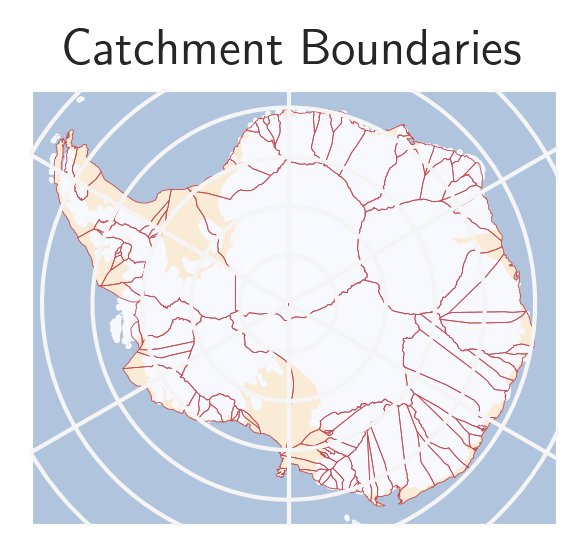

In [5]:
# Plot boundaries

plt.figure(figsize=(5,5))
ax1 = plt.subplot(121,projection=ccrs.SouthPolarStereo())
ax1.gridlines(color='whitesmoke',zorder=4)
icems[34:133].plot(ax=ax1,color='antiquewhite', linewidth=0,zorder=1)
icems[34:133].boundary.plot(ax=ax1,color='r', linewidth=0.2,zorder=3)
#icems[34:133].boundary.plot(ax=ax1,linewidth=0.25,color='lightgray',zorder=4)
#ax1.coastlines(resolution='10m', zorder=6,linewidth=0.75)
ax1.patch.set_facecolor(color='lightsteelblue')
#ax1.add_feature(cartopy.feature.LAND, color='ghostwhite')
ax1.add_feature(cartopy.feature.LAND, color='ghostwhite', zorder=2)
plt.title('Catchment Boundaries');

In [ ]:
flux_draft_dependence = flux_dedrafted[300:] - flux_clean

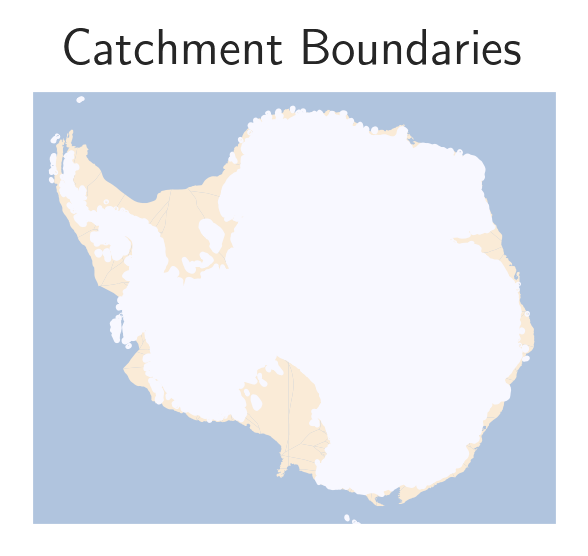

In [6]:
# Plot boundaries

plt.figure(figsize=(5,5))
ax1 = plt.subplot(121,projection=ccrs.SouthPolarStereo())
#ax1.gridlines(color='whitesmoke',zorder=4)
icems[34:133].plot(ax=ax1,color='antiquewhite', linewidth=0,zorder=1)
#icems[34:133].boundary.plot(ax=ax1,color='r', linewidth=0.2,zorder=3)
#icems[34:133].boundary.plot(ax=ax1,linewidth=0.25,color='lightgray',zorder=4)
#ax1.coastlines(resolution='10m', zorder=6,linewidth=0.75)
ax1.patch.set_facecolor(color='lightsteelblue')
#ax1.add_feature(cartopy.feature.LAND, color='ghostwhite')
ax1.add_feature(cartopy.feature.LAND, color='ghostwhite', zorder=2)
plt.title('Catchment Boundaries');

In [ ]:
#from sklearn.preprocessing import MinMaxScaler

#scale_norm = MinMaxScaler()
#catchments_scatter_scaled = scale_norm.fit_transform(catchments_scatter) 

## Figure 2

Scatterplot of Antarctic catchments

In [ ]:
# Figure: Melt rate draft dependence for select catchments
# The following indices are taken from 'catchment_scatter', defined as
# Index of catchments in catchment_scatter = Index of catchments in icems - 33

# Sample ice shelves chosen:
# Amery = 1
# George VI = 27
# Getz = 28
# Pine Island = 61
# Ronne = 70
# Totten = 83
# Wilkins = 94
# Western Ross = 71
# Filchner = 22
# Thwaites = 81
# Eastern_Ross = 72

# Full list of ice shelves and indices can be obtained by printing icems

#catchments = np.array([1,27,28,61,70,83,94,71,22])

catchments = np.array([1,27,28,61,70,83])
basins=catchments+33

sns.set_theme(style="whitegrid")
#fig, ax = plt.subplots(1, 1, figsize=[15, 15],subplot_kw={'projection': ccrs.SouthPolarStereo()})
fig, axs = plt.subplots(2,3, figsize=[15, 10])
axs=axs.ravel()

#label in enumerate(('A', 'B', 'C', 'D'))

for i,label in enumerate(('(a)', '(b)', '(c)', '(d)', '(e)', '(f)')):
    axs[i].scatter(catchments_scatter[catchments[i]],ssh[1],color='r',s=1)
    #axs[i].set_xlabel('Melt Flux (kg / m2 / s)')
    #axs[i].set_ylabel('Depth (m)')
    axs[i].set_ylim(-1000,0) # Specified for consistency across plots, some catchments are not as deep as others
    # Uncomment to set xlim values for easy comparison of forcing magnitudes (varies across ice shelves)
    #axs[i].set_xlim(-0.5e-6,2e-5)
    axs[i].set_title('{}'.format(icems.name[33+catchments[i]]))
    axs[i].text(-0.04, 1.08, label, transform=axs[i].transAxes ,fontweight='bold', va='top')
    # axs[i].inset_axes([], projection=crs) does not seem to work, hence the workaround below:
    # Refer here: https://github.com/matplotlib/matplotlib/pull/22608 for future revisions
    axins = inset_axes(axs[i],width="30%", height="30%", loc="upper right", 
                       axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                       axes_kwargs=dict(projection=ccrs.SouthPolarStereo()))
    icems[33:133].plot(ax=axins,linewidth=0.3,color='lightsteelblue')
    axins.coastlines(resolution='10m',linewidth=0.25)
    icems.loc[[33+catchments[i]],'geometry'].plot(ax=axins,color='r',linewidth=0.4)
    #axs[i].set_axis_off();
    axins.set_axis_off();
    axs[i].grid(alpha=0.5)
    #axs[i].set_xscale("log");
    #axs[i].set_yscale("log");
    
#for ax in axs.flat:
#    ax.label_outer()

axs[0].set_ylabel('Depth (m)'); # Ice Draft?
axs[3].set_ylabel('Depth (m)');
#axs[6].set_ylabel('Depth (m)');


"""
axs[0].set_xlim(0.0,0.6)
axs[1].set_xlim(0.0,0.6)
axs[2].set_xlim(0.0,0.6)

axs[3].set_xlim(-0.03,0.03)
axs[4].set_xlim(-0.03,0.03)
axs[5].set_xlim(-0.03,0.03)

"""

axs[1].tick_params(labelleft=False, left=False)
axs[2].tick_params(labelleft=False)

axs[4].tick_params(labelleft=False, left=False)
axs[5].tick_params(labelleft=False)

#fig.supylabel('Depth ($m$)');
#fig.supxlabel('Melt Rate ($m/yr$)');

axs[3].set_xlabel('Melt Rate ($m/yr$)');
axs[4].set_xlabel('Melt Rate ($m/yr$)');
axs[5].set_xlabel('Melt Rate ($m/yr$)');

plt.subplots_adjust(wspace=0.05, hspace=0.18)

# TODO: Convert to m SLE units for flux

## Fig 3

Relative power of eigenmodes:

* Model output variability data (`flux_clean`)
* Normalized model output variability data (`flux_clean_normalized`) 

In [ ]:
# Input data

F_v_varexpl = xr.open_dataset(inDirName+processed_data_folder+pca_1+"varexpl.nc")
F_vn_varexpl = xr.open_dataset(inDirName+processed_data_folder+pca_2+"norm_varexpl.nc")

F_v_varexpl = F_v_varexpl.explained_variance_ratio
F_vn_varexpl = F_vn_varexpl.explained_variance_ratio

In [ ]:
Fv_cs = F_v_varexpl.cumsum()
Fvn_cs = F_vn_varexpl.cumsum()

In [ ]:
Fv_cs[500:800].plot()
Fvn_cs[500:800].plot()

In [ ]:
# Plot figure
# Figure: Relative power of m EOFs

m = 1500
sns.set_theme(style="whitegrid")

#ax = plt.subplot(111)

# Change figsize parameters to adjust size of all elements at once - might not be optimal. 
# Commented code snippets allow for better control
ax = plt.figure(figsize=(8,5))
plt.plot(range(m),Fv_cs[:m]*100, 'k*-', lw=1.2,
         label='Actual Data: {:.2f}\%'.format(F_v_varexpl[:m].sum().values*100))
plt.plot(range(m),Fvn_cs[:m]*100, 'rh-', lw=1.2,markersize=4,
         label='Normalized Data: {:.2f}\%'.format(F_vn_varexpl[:m].sum().values*100))
plt.ylabel('Relative Power (\%)')
plt.xlabel('EOF Mode Number')
plt.title('Explained Variance of first {} EOF modes'.format(m));
plt.legend();


#ax.title.set_fontsize(18)
#ax.xaxis.label.set_fontsize(18)
#ax.yaxis.label.set_fontsize(18)


In [ ]:
Fvn_cs[750]

In [ ]:
# Plot figure
# Figure: Relative power of m EOFs

#plt.rcParams['font.size'] = 25

"""
plt.rc('font', size=20) # Set the default text font size
plt.rc('axes', titlesize=16) # Set the axes title font size
plt.rc('axes', labelsize=16) # Set the axes labels font size
plt.rc('xtick', labelsize=16) # Set the font size for x tick labels
plt.rc('ytick', labelsize=16) # Set the font size for y tick labels
plt.rc('legend', fontsize=18) # Set the legend font size
plt.rc('figure', titlesize=20) # Set the font size of the figure title
"""


m = 125
sns.set_theme(style="whitegrid")

#ax = plt.subplot(111)

# Change figsize parameters to adjust size of all elements at once - might not be optimal. 
# Commented code snippets allow for better control
ax = plt.figure(figsize=(8,5))
plt.plot(range(m),F_v_varexpl[:m]*100, 'k*-', lw=1.2,
         label='Actual Data: {:.2f}\%'.format(F_v_varexpl[:m].sum().values*100))
plt.plot(range(m),F_vn_varexpl[:m]*100, 'rh-', lw=1.2,markersize=4,
         label='Normalized Data: {:.2f}\%'.format(F_vn_varexpl[:m].sum().values*100))
plt.ylabel('Relative Power (\%)')
plt.xlabel('EOF Mode Number')
plt.title('Explained Variance of first {} EOF modes'.format(m));
plt.legend();


#ax.title.set_fontsize(18)
#ax.xaxis.label.set_fontsize(18)
#ax.yaxis.label.set_fontsize(18)


## Fig 4

Decomposition on normalized model output variability data 

In [ ]:
# Input data

F_vn_eofs = xr.open_dataset(inDirName+processed_data_folder+pca_2+"norm_eofs_eig.nc")
F_vn_pcs = xr.open_dataset(inDirName+processed_data_folder+pca_2+"norm_pcs_eig.nc")


F_vn_eofs = F_vn_eofs.EOFs
F_vn_pcs = F_vn_pcs.PCs

#F_vn_eofs = F_vn_eofs*sec_per_year/rho_fw
#F_vn_pcs = F_vn_pcs*sec_per_year/rho_fw

In [ ]:
# Normalize melt rate, as input datasets were earlier done for flux. 

In [ ]:
#flux_clean = flux_clean*sec_per_year/rho_fw
flux_clean_tmean = flux_clean.mean('time')
flux_clean_tstd = flux_clean.std('time')

flux_clean_demeaned = flux_clean - flux_clean_tmean
flux_clean_normalized = flux_clean_demeaned/flux_clean_tstd

In [ ]:
%%time
model = EOF(flux_clean_normalized) # change accordingly if using original data, or normalized data
model.solve()
eofs = model.eofs()
pcs = model.pcs()
nmodes = model.n_modes

In [ ]:
eofs_eig = model.eofs(1)
pcs_eig = model.pcs(1)

In [ ]:
# Plot figure
# Figure: EOF modes from decomposition of normalized model variability data

nmodes_plot = 3 # Number of modes to plot

panels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)']

varpanel = '(a)'
eofpanels = ['(b)','(d)','(f)']
pcpanels = ['(c)','(e)','(g)']

yr_length = range(0,125)
yrs_plot = np.repeat(yr_length, 12)

#sns.set_theme()
sns.set_theme(style="whitegrid")
fig=plt.figure(figsize=(12,8))
gs = GridSpec(nmodes_plot,3,width_ratios=[1.25,1,1.25])
axbig = fig.add_subplot(gs[:, 0])
ax0 = [fig.add_subplot(gs[i, 1],projection=crs) for i in range(nmodes_plot)]
ax1 = [fig.add_subplot(gs[i, 2]) for i in range(nmodes_plot)]

for i, (a0, a1) in enumerate(zip(ax0, ax1)):
    F_vn_eofs.sel(mode=i+1).plot(ax=a0,
                            cmap='cmo.balance',
                            add_colorbar=True,
                            cbar_kwargs={'orientation': 'vertical',
                                         'label': 'SD Units'})
    a0.coastlines(resolution='10m',linewidth=0.25,color='0.8')
    a0.set_title('EOF {}'.format(i+1))
    a0.text(-0.02, 1.1, eofpanels[i], transform=a0.transAxes ,fontweight='bold', va='top')
    a1.set_ylim(-3,3)
    #a1.set_xlim(0,1500)
    a1.plot(F_vn_pcs.sel(mode=i+1),linewidth=1,color='dimgray')
    a1.set_xlabel('')
    a1.set_title('PC {}'.format(i+1))
    a1.tick_params(labelbottom=False, left=False, grid_alpha=0.3)
    a1.text(-0.02, 1.1, pcpanels[i], transform=a1.transAxes ,fontweight='bold', va='top')

a1.set_xlabel('Time (months)');

# fig.suptitle("Leading {} modes of normalized model output".format(nmodes_plot))
# Remove x axis for time series plots on top
#ax1[0].tick_params(labelbottom=False, left=False, grid_alpha=0.3)
#ax1[1].tick_params(labelbottom=False, left=False, grid_alpha=0.3)
#ax1[2].tick_params(labelbottom=True, left=False, grid_alpha=0.3)
ax1[2].tick_params(labelbottom=True)

#ax0[0].set_title("EOF Mode 1");
#ax0[1].set_title("Mode 2");
#ax0[2].set_title("Mode 3");
#ax1[0].set_title("PCs");

m = 300
xvar = np.linspace(1,m,m)
axbig.plot(xvar,Fv_cs[:m]*100, 'k*--', lw=0.5,markersize=3.75,
         label='Actual Data: {:.2f}\%'.format(F_v_varexpl[:m].sum().values*100))

axbig.plot(xvar,Fvn_cs[:m]*100,'x--', lw=0.5,markersize=3.75,
         label='Normalized Data: {:.2f}\%'.format(F_vn_varexpl[:m].sum().values*100),color='slategray')
axbig.set_ylabel('Cumulative variance captured (\%)')
axbig.set_xlabel('Mode Number')
axbig.set_title('Cumulative variance captured by first {} modes'.format(m));
axbig.tick_params(labelbottom=True, left=False, grid_alpha=0.3)
axbig.legend();
axbig.text(-0.08, 1.03, '(a)', transform=axbig.transAxes ,fontweight='bold', va='top')


plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
#plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig.tight_layout()

In [ ]:
# Plot figure
# Figure: EOF modes from decomposition of normalized model variability data

nmodes_plot = 3 # Number of modes to plot

yr_length = range(0,125)
yrs_plot = np.repeat(yr_length, 12)

#sns.set_theme()
sns.set_theme(style="whitegrid")
fig=plt.figure(figsize=(12,8))
gs = GridSpec(nmodes_plot,2,width_ratios=[1.5,2])
axbig = fig.add_subplot(gs[0,:])
ax0 = [fig.add_subplot(gs[i,0],projection=crs) for i in range(1,nmodes_plot)]
ax1 = [fig.add_subplot(gs[i,1]) for i in range(1,nmodes_plot)]

for i, (a0, a1) in enumerate(zip(ax0, ax1)):
    F_vn_eofs.sel(mode=i+1).plot(ax=a0,
                            cmap='cmo.balance',
                            add_colorbar=True,
                            cbar_kwargs={'orientation': 'vertical',
                                         'label': 'SD Units'})
    a0.coastlines(resolution='10m',linewidth=0.25,color='0.8')
    a0.set_title('EOF Mode {}'.format(i+1))
    a1.set_ylim(-3,3)
    a1.plot(F_vn_pcs.sel(mode=i+1),linewidth=1,color='dimgray')
    a1.set_xlabel('')
    a1.set_title('PC Mode {}'.format(i+1))
    a1.tick_params(labelbottom=False, left=False, grid_alpha=0.3)

a1.set_xlabel('Time (months)');

# fig.suptitle("Leading {} modes of normalized model output".format(nmodes_plot))
# Remove x axis for time series plots on top
#ax1[0].tick_params(labelbottom=False, left=False, grid_alpha=0.3)
#ax1[1].tick_params(labelbottom=False, left=False, grid_alpha=0.3)
#ax1[2].tick_params(labelbottom=True, left=False, grid_alpha=0.3)
#ax1[2].tick_params(labelbottom=True)

#ax0[0].set_title("EOF Mode 1");
#ax0[1].set_title("Mode 2");
#ax0[2].set_title("Mode 3");
#ax1[0].set_title("PCs");

m = 500
xvar = np.linspace(1,m,m)
axbig.plot(xvar,Fv_cs[:m]*100, 'k*--', lw=0.5,markersize=1.75,
         label='Actual Data: {:.2f}\%'.format(F_v_varexpl[:m].sum().values*100))
axbig.plot(xvar,Fvn_cs[:m]*100, 'rh--', lw=0.5,markersize=0.75,
         label='Normalized Data: {:.2f}\%'.format(F_vn_varexpl[:m].sum().values*100))
axbig.set_ylabel('Cumulative variance captured (\%)')
axbig.set_xlabel('Mode Number')
axbig.set_title('Cumulative variance captured by first {} modes'.format(m));
axbig.tick_params(labelbottom=True, left=False, grid_alpha=0.3)
axbig.legend();

fig.tight_layout()

In [ ]:
# Plot figure
# Figure: EOF modes from decomposition of normalized model variability data

nmodes_plot = 3 # Number of modes to plot

yr_length = range(0,125)
yrs_plot = np.repeat(yr_length, 12)

#sns.set_theme()
sns.set_theme(style="whitegrid")
fig=plt.figure(figsize=(13,8))
gs = GridSpec(2,nmodes_plot,width_ratios=[1,1,1])
ax0 = [fig.add_subplot(gs[0, i],projection=crs) for i in range(nmodes_plot)]
ax1 = [fig.add_subplot(gs[1, i]) for i in range(nmodes_plot)]

for i, (a0, a1) in enumerate(zip(ax0, ax1)):
    F_vn_eofs.sel(mode=i+1).plot(ax=a0,
                            cmap='cmo.balance',
                            add_colorbar=False)#,
                            #cbar_kwargs={'orientation': 'vertical',
                            #             'label': 'SD Units'})
    a0.coastlines(resolution='10m',linewidth=0.25,color='0.8')
    a1.set_ylim(-3,3)
    a1.plot(F_vn_pcs.sel(mode=i+1),linewidth=1,color='dimgray')
    a1.set_xlabel('')

a1.set_xlabel('Time (months)');

# fig.suptitle("Leading {} modes of normalized model output".format(nmodes_plot))
# Remove x axis for time series plots on top
ax1[0].tick_params(labelbottom=False, left=False, grid_alpha=0.3)
ax1[1].tick_params(labelbottom=False, left=False, grid_alpha=0.3)
ax1[2].tick_params(labelbottom=True, left=False, grid_alpha=0.3)

ax0[0].set_title("EOF Mode 1");
ax0[1].set_title("Mode 2");
ax0[2].set_title("Mode 3");
ax1[0].set_title("PCs");

plt.tight_layout()

In [ ]:
# Plot figure
# Figure: EOF modes from decomposition of normalized model variability data
"""
nmodes_plot = 3 # Number of modes to plot

sns.set_theme(style="white")
fig=plt.figure(figsize=(10,8))
gs = GridSpec(nmodes_plot,2,width_ratios=[1.5,2.5])
ax0 = [fig.add_subplot(gs[i, 0],projection=crs) for i in range(nmodes_plot)]
ax1 = [fig.add_subplot(gs[i, 1]) for i in range(nmodes_plot)]

for i, (a0, a1) in enumerate(zip(ax0, ax1)):
    F_vn_eofs.sel(mode=i+1).plot(ax=a0,
                            cmap='cmo.balance',
                            add_colorbar=True,
                            cbar_kwargs={'orientation': 'vertical',
                                         'label': 'Standard Deviation Units'})
    a0.coastlines(resolution='10m',linewidth=0.25,color='0.8')
    a1.plot(F_vn_pcs.sel(mode=i+1),linewidth=1,color='dimgray')
    a1.set_xlabel('')

a1.set_xlabel('Time (months)');

"""

## Fig 5

Generator variability output (select 3 basins, time series + power spectral densities)
Possibly add time stamped spatial fields as inset?

In [7]:
# Input data
# Ensure this has been multipled by sec_per_year/rho_fw for melt rate units

flux_clean = xr.open_dataset(inDirName+interim_data_folder+'flux_clean')
Fvgen01 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"spca_a01/spca_a01_REC0.nc")
Fvgen1 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"spca_a1/spca_a1_REC0.nc")
Fvgen3a = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"spcabatch_a3/spcabatch_a3_REC0.nc")
Fvgen3b = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"spcabatch_a3/spcabatch_a3_REC1.nc")
Fvgen10 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"spcabatch_a10/spcabatch_a10_REC0.nc")
Fvrec0 = xr.open_dataset(inDirName+processed_data_folder+pca_3+"REC0.nc")
Fvrec1 = xr.open_dataset(inDirName+processed_data_folder+pca_3+"REC1.nc")
Fvrec2 = xr.open_dataset(inDirName+processed_data_folder+pca_3+"REC2.nc")

sec_per_year = 365*24*60*60
rho_fw = 1000

Fv = flux_clean.timeMonthly_avg_landIceFreshwaterFlux*sec_per_year/rho_fw
Fvgen01 = Fvgen01.__xarray_dataarray_variable__*sec_per_year/rho_fw
Fvgen1 = Fvgen1.__xarray_dataarray_variable__*sec_per_year/rho_fw
Fvgen3a = Fvgen3a.__xarray_dataarray_variable__*sec_per_year/rho_fw
Fvgen3b = Fvgen3b.__xarray_dataarray_variable__*sec_per_year/rho_fw
Fvgen10 = Fvgen10.__xarray_dataarray_variable__*sec_per_year/rho_fw
Fvrec0 = Fvrec0.__xarray_dataarray_variable__*sec_per_year/rho_fw
Fvrec1 = Fvrec1.__xarray_dataarray_variable__*sec_per_year/rho_fw
Fvrec2 = Fvrec2.__xarray_dataarray_variable__*sec_per_year/rho_fw

Fv = Fv.rename('orig')
Fvgen01 = Fvgen01.rename('gen01')
Fvgen1 = Fvgen1.rename('gen1')
Fvgen3a = Fvgen3a.rename('gen3a')
Fvgen3b = Fvgen3b.rename('gen3b')
Fvgen10 = Fvgen10.rename('gen10')
Fvrec0 = Fvrec0.rename('rec0')
Fvrec1 = Fvrec1.rename('rec1')
Fvrec2 = Fvrec2.rename('rec2')

### Animations - Spatial fields

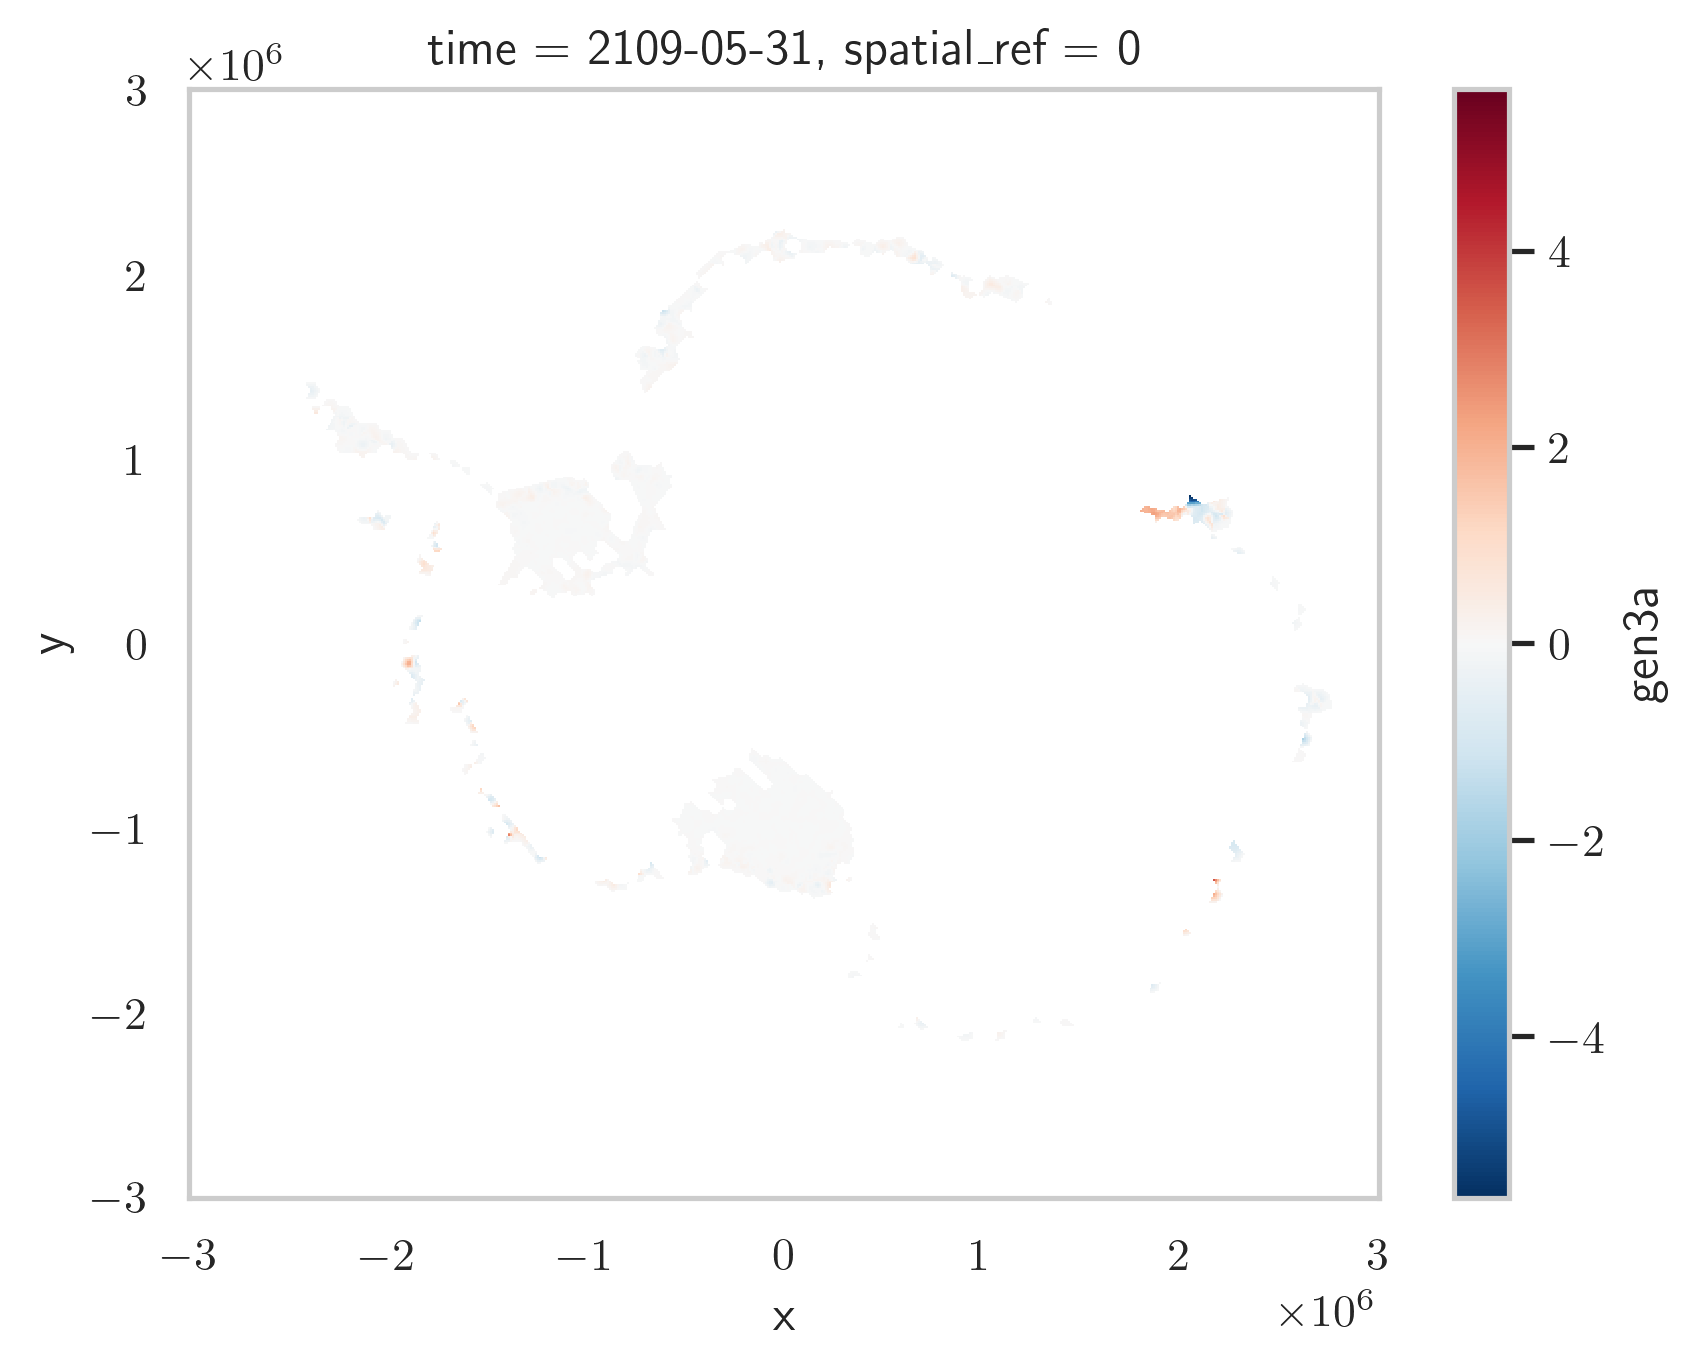

In [25]:
sns.set_theme(style="whitegrid")
Fvgen3a[1000].plot()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


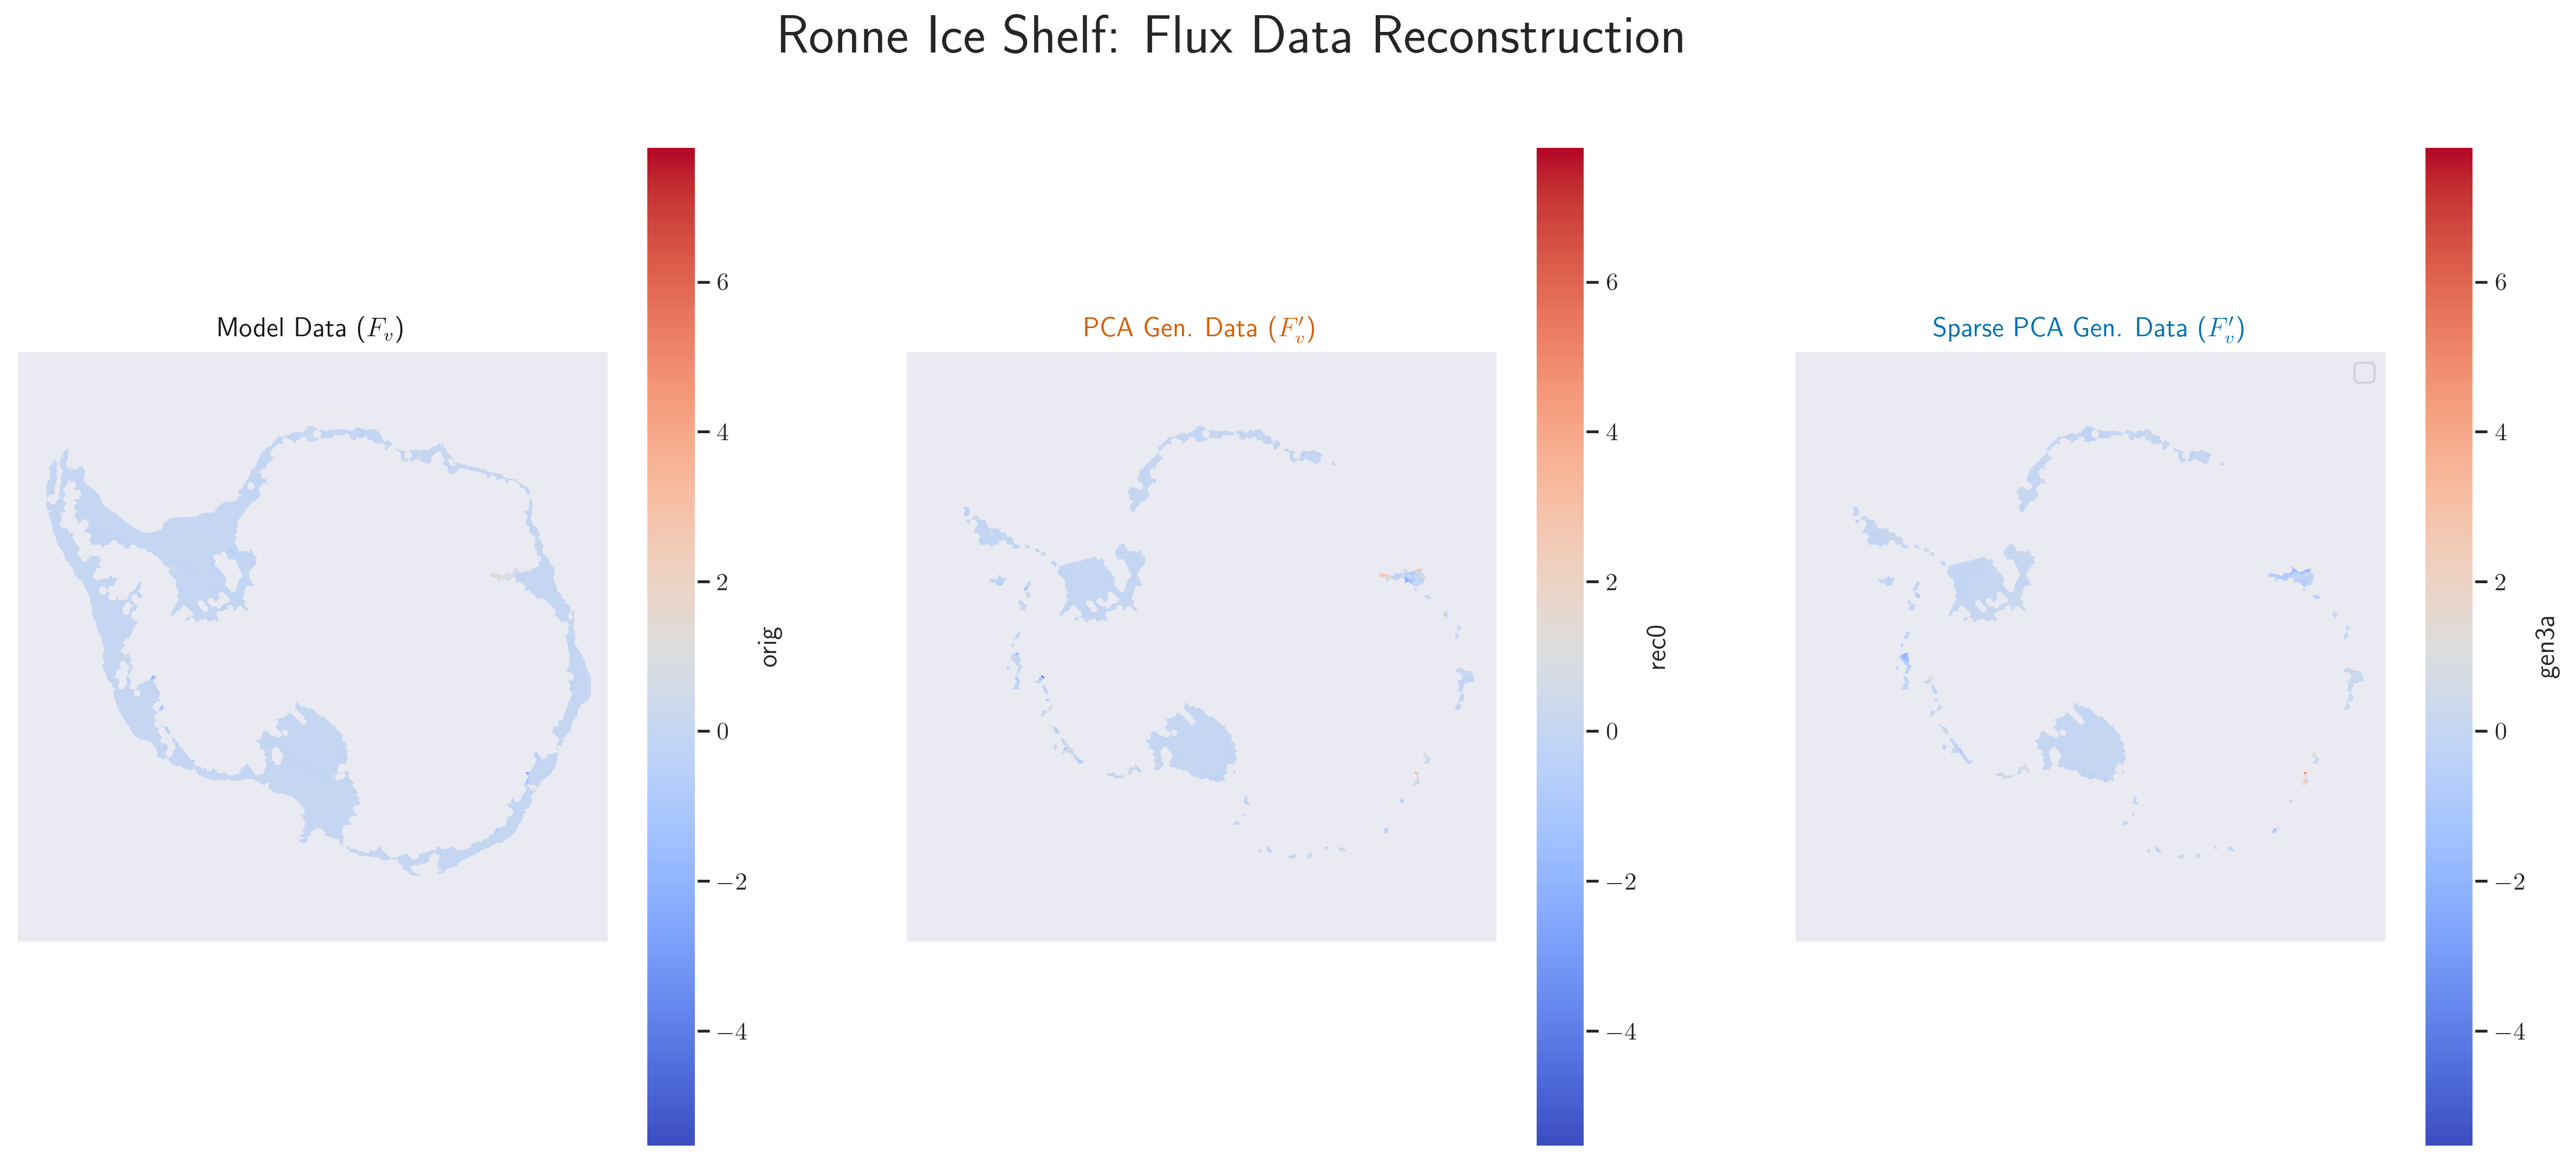

In [21]:
##==================================================
##==============ANIMATION===========================
##==================================================
# Flux trend in time: Contourf animation

# Get a handle on the figure and the axes
fig, axs = plt.subplots(1,3,figsize=(20,8), subplot_kw={'projection': ccrs.SouthPolarStereo()})

# vmin=-0.000005
# vmax=0.0008

sns.set_theme(style="whitegrid")

oc = 'k'
pcac = '#D55E00'#'#FC8D62'
spcac = '#0072B2' #'#CC79A7'

lwbg = 0.1
lworig = 1.8
lwgen = 0.75


#axs[0, 0].set_title('Axis [0, 0]')

# Plot the initial frame.
# vmin = np.min(flux), vmax = np.max(flux) obtained manually. These should be modified to skip ocean flux values

colorbarmax = np.nanmax([Fv, Fvrec0, Fvgen3a])
colorbarmin = np.nanmin([Fv, Fvrec0, Fvgen3a])

plt.suptitle('Ronne Ice Shelf: Flux Data Reconstruction')
plt.subplot(131)
cax1 = Fv[1,:,:].plot(add_colorbar=True, 
                       cmap='coolwarm', vmax = colorbarmax/2, vmin = colorbarmin/2,
                       cbar_kwargs={'extend':'neither'})
#plt.title("Original Data: " + str(orig_ameryn.coords['time'].values[frame])[:7])
plt.title("Model Data ($F_v$)", color= oc, fontweight='bold')


plt.subplot(132)
cax2 = Fvrec0[1,:,:].plot(add_colorbar=True, 
                          cmap='coolwarm', vmax = colorbarmax/2, vmin = colorbarmin/2,
                          cbar_kwargs={'extend':'neither'})
#plt.title("Phase Randomized Data: " + str(rec_ameryn.coords['time'].values[frame])[:7])
plt.title("PCA Gen. Data ($F'_v$)", color= pcac, fontweight='bold')

plt.subplot(133)
cax3 = Fvgen3a[1,:,:].plot(add_colorbar=True, 
                           cmap='coolwarm', vmax = colorbarmax/2, vmin = colorbarmin/2,
                           cbar_kwargs={'extend':'neither'})
#plt.title("Phase Randomized Data: " + str(rec_ameryn.coords['time'].values[frame])[:7])
plt.title("Sparse PCA Gen. Data ($F'_v$)", color= spcac, fontweight='bold')


#plt.subplot(2,3,[4,5,6])
#plt.subplot(212)
#cax4, = plt.plot(orig_basin_ts, 'k', linewidth=1.5, label = 'Original Data')
#cax5, = plt.plot(rec_basin_ts,  'b', linewidth=0.55, label = 'Phase Randomized Data (within basin)')
#cax6, = plt.plot(flux_ais_basin_ts,  'b', linewidth=0.15, label = 'Phase Randomized Data (across AIS)')

plt.legend()

# Next we need to create a function that updates the values for the colormesh, as well as the title.
def animate(frame):
    cax1.set_array(Fv[frame,:,:].values.flatten())
    cax2.set_array(Fvgen3a[frame,:,:].values.flatten())
    cax3.set_array(Fvrec0[frame,:,:].values.flatten())
    #cax4.set_ydata(orig_basin_ts[:frame]) # ANIMATED
    #cax4.set_xdata(range(frame)) # ANIMATED
    #cax4.set_marker('.')
    #cax4.set_markersize(0.25)
    #cax5.set_ydata(rec_basin_ts[:frame])
    #cax5.set_xdata(range(frame))
    #cax5.set_marker('.')
    #cax5.set_markersize(0.25)
    #cax6.set_ydata(flux_ais_basin_ts[:frame])
    #cax6.set_xdata(range(frame))
    #cax6.set_marker('.')
    #cax6.set_markersize(0.25)

# Finally, we use the animation module to create the animation.
ani2 = animation.FuncAnimation(
    fig,             # figure
    animate,         # name of the function above
    frames=10,  # Could also be iterable or list
    interval=100     # ms between frames
)

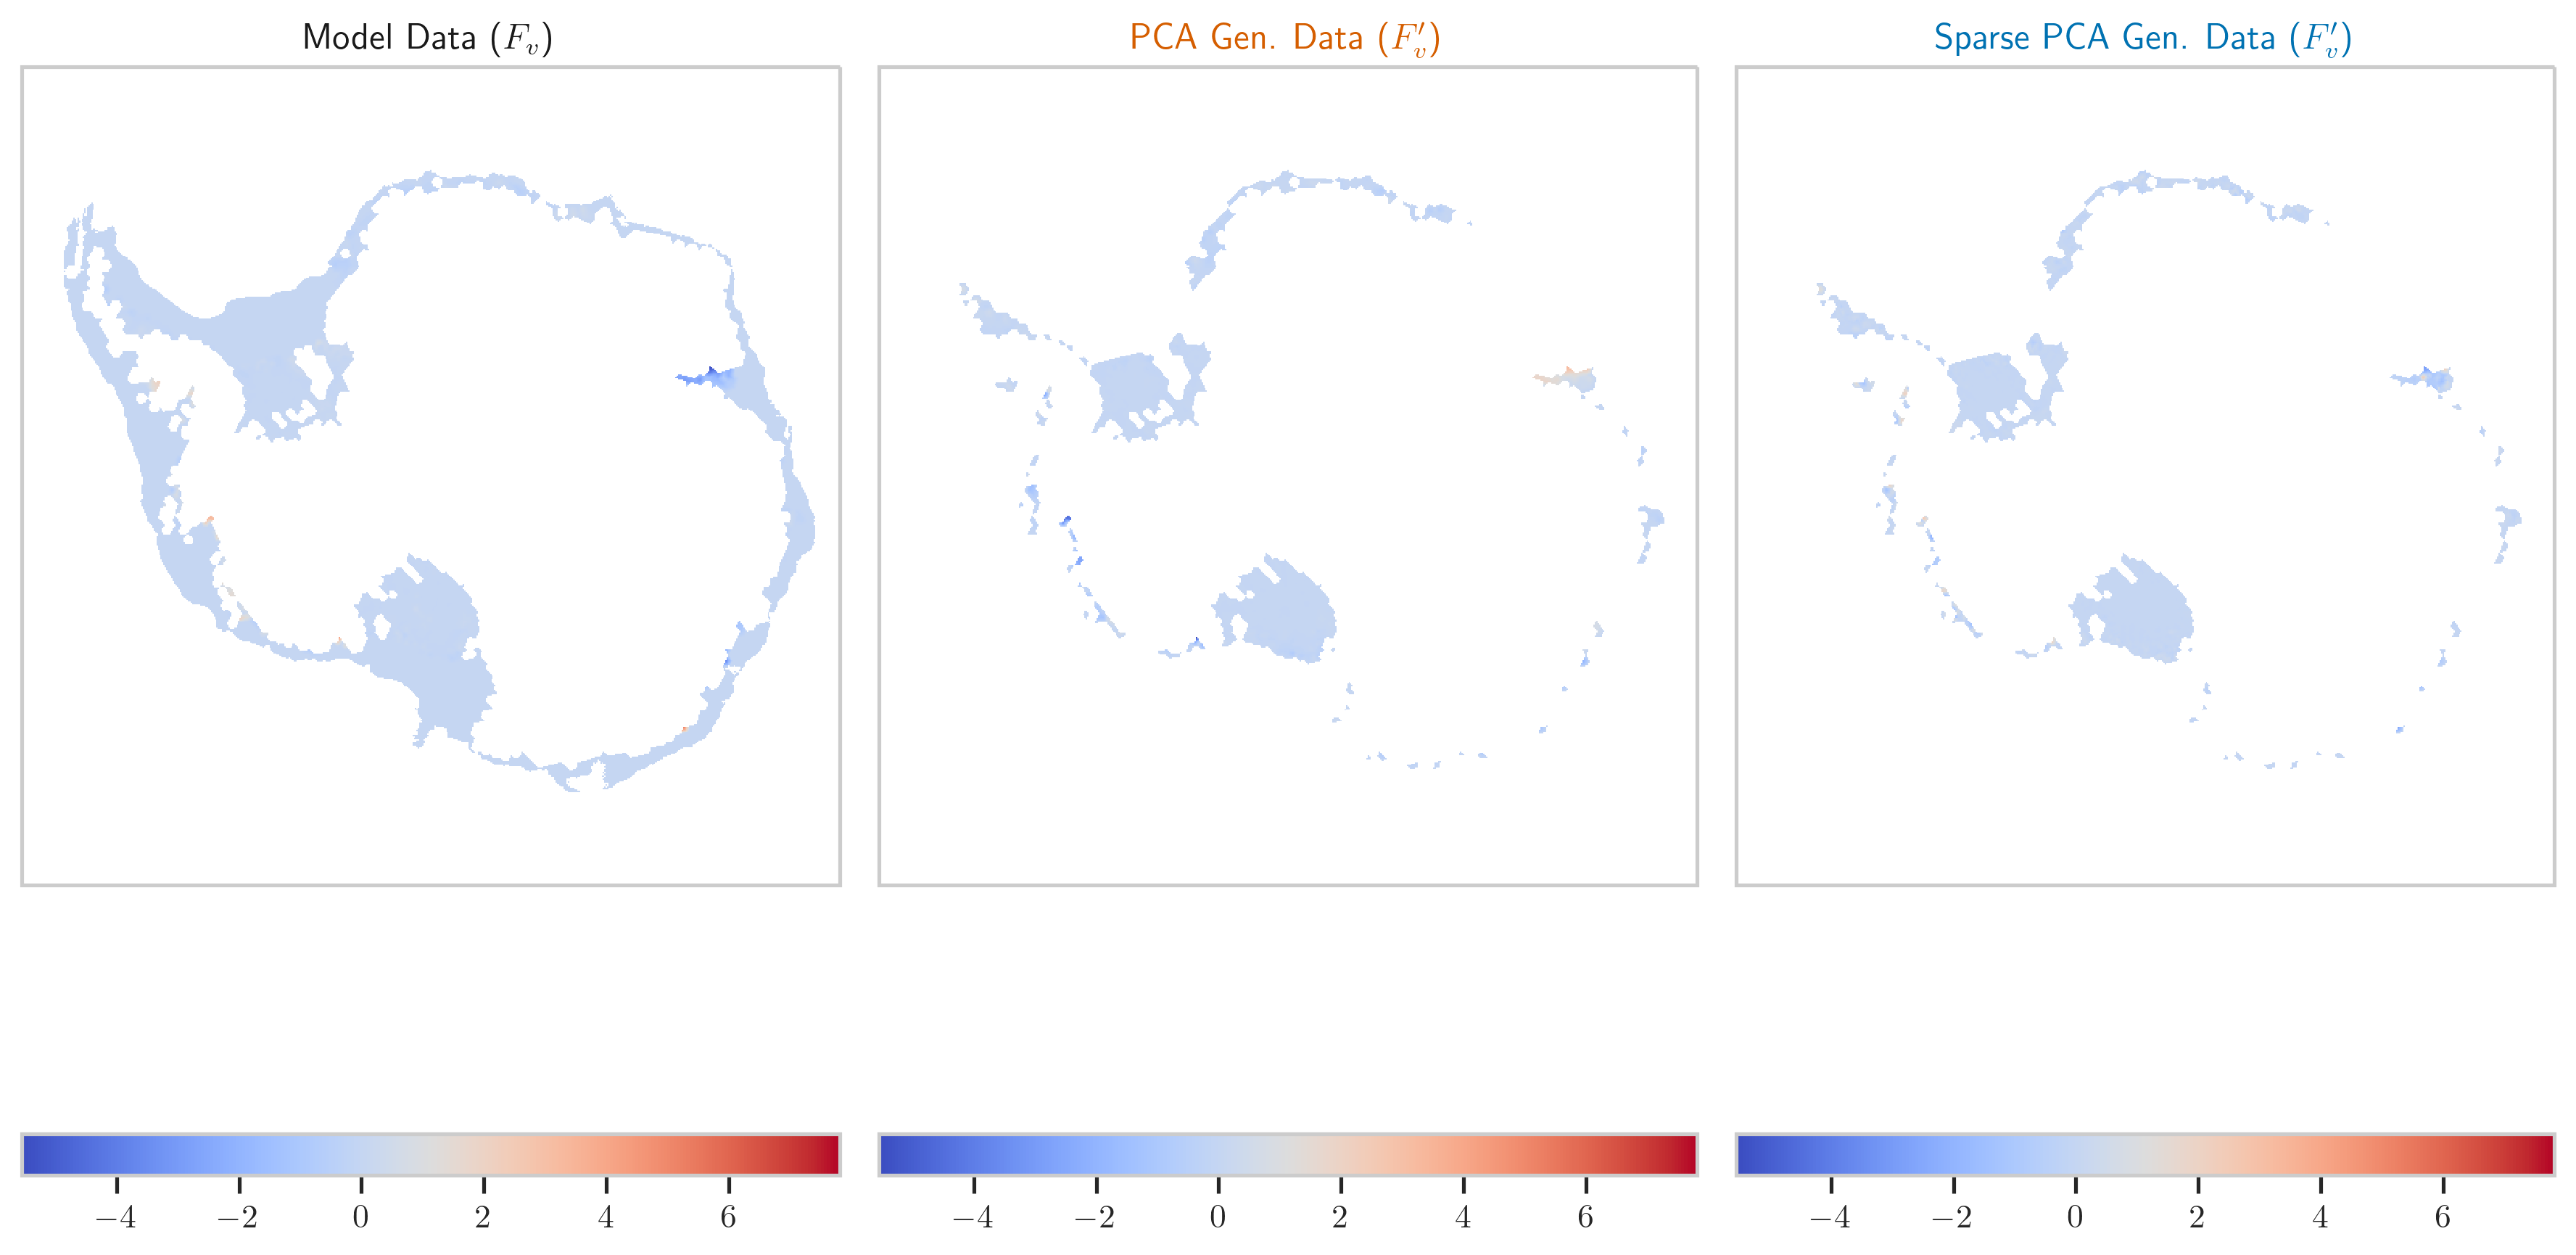

In [61]:
fig, axs = plt.subplots(1,3,figsize=(12,8), subplot_kw={'projection': ccrs.SouthPolarStereo()})

#plt.suptitle('Spatial variability in basal melt rates')
plt.subplot(131)
cax1 = Fv[100,:,:].plot(add_colorbar=False, 
                       cmap='coolwarm', vmax = colorbarmax/2, vmin = colorbarmin/2)#,
                       #cbar_kwargs={'extend':'neither'})
#plt.title("Original Data: " + str(orig_ameryn.coords['time'].values[frame])[:7])
plt.title("Model Data ($F_v$)", color= oc, fontweight='bold');


plt.subplot(132)
cax2 = Fvrec0[100,:,:].plot(add_colorbar=False, 
                          cmap='coolwarm', vmax = colorbarmax/2, vmin = colorbarmin/2)#,
                          #cbar_kwargs={'extend':'neither'})
#plt.title("Phase Randomized Data: " + str(rec_ameryn.coords['time'].values[frame])[:7])
plt.title("PCA Gen. Data ($F'_v$)", color= pcac, fontweight='bold');

plt.subplot(133)
cax3 = Fvgen3a[100,:,:].plot(add_colorbar=False, 
                           cmap='coolwarm', vmax = colorbarmax/2, vmin = colorbarmin/2)#,
                           #cbar_kwargs={'extend':'neither'})
#plt.title("Phase Randomized Data: " + str(rec_ameryn.coords['time'].values[frame])[:7])
plt.title("Sparse PCA Gen. Data ($F'_v$)", color= spcac, fontweight='bold');

#divider = make_axes_locatable(ax)
#cax = divider.append_axes("bottom", size="15%", pad=0.05)
#fig.colorbar(cax1, cax=cax)

cbar1 = fig.colorbar(cax1, location="bottom",cmap="cmo.balance")
cbar2 = fig.colorbar(cax2, location="bottom",cmap="cmo.balance")
cbar3 = fig.colorbar(cax3, location="bottom",cmap="cmo.balance")

plt.tight_layout()
#fig.colorbar(cax1,  loc="bottom", cmap = 'cmo.ocean')#, labelsize= 22, label = units, shrink = 1)

In [28]:
HTML(ani2.to_jshtml())
#ani2.save(inDirName+figures_folderpath+'{}_basinEOF_comparison.mp4'.format(icems.name.values[basin]))

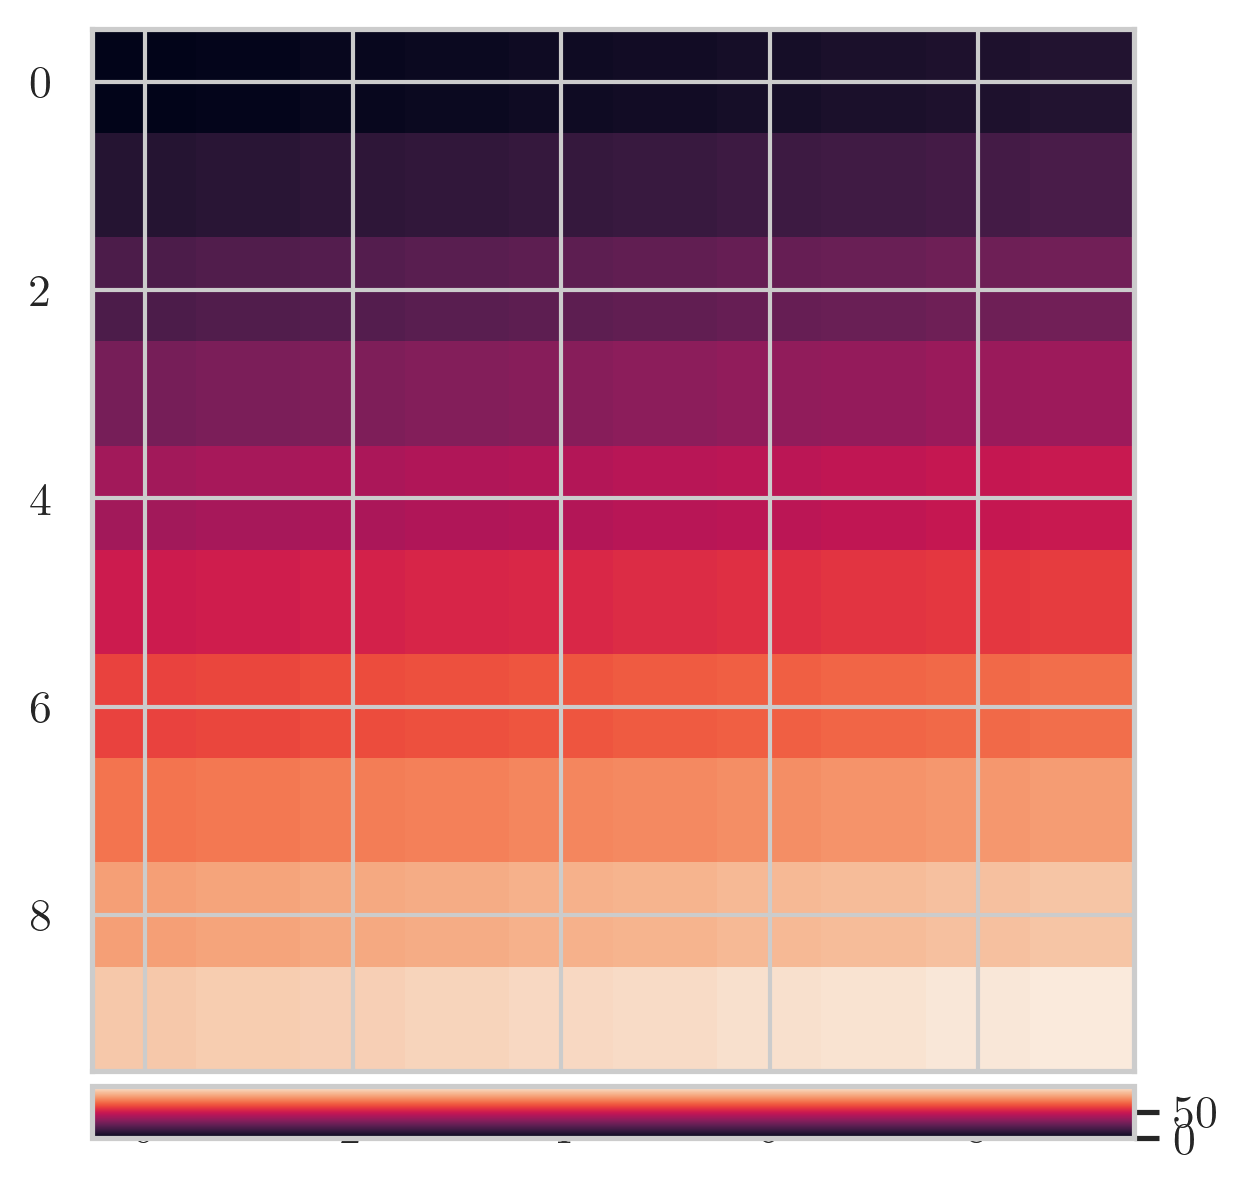

In [ ]:
fullais = xr.merge([Fv,Fvgen01,Fvgen1,Fvgen3a, Fvrec0,Fvrec1,Fvrec2])
#fullais.to_netcdf(inDirName+processed_data_folder+"fullAIS_combined.nc")
fullais_ts = time_series(fullais)
#fullais_ts.to_netcdf(inDirName+processed_data_folder+"fullAIS_combined_ts.nc")

In [ ]:
fullais = xr.open_dataset(inDirName+processed_data_folder+"fullAIS_combined.nc")
fullais_ts = xr.open_dataset(inDirName+processed_data_folder+"fullAIS_combined_ts.nc")

In [ ]:
fullais.rec0[100].plot()

In [ ]:
#modified to not return f - in calculation of RMSE, only Px required
def psd_calc_grid(data,y,x):
    f, Px = scipy.signal.welch(data[:,y,x])
    return Px

def time_series(clipped_data):
    clipped_ts = clipped_data.sum(['y','x'])
    return clipped_ts

# Reconstruct flux dataset using phase randomized PCs
# This section is to be called iteratively for ensemble runs with multiple realizations
# This method also takes 'modes' as a parameter: 
# which is used to reconstruct dataset with different number of selected modes

def generate_data(n_realization,mode,mode_skip):
    flux_reconstr = model.reconstruct_randomized_X(new_fl[n_realization],slice(1,mode,mode_skip))
    #flux_reconstr = flux_reconstr.dropna('time',how='all')
    #flux_reconstr = flux_reconstr.dropna('y',how='all')
    #flux_reconstr = flux_reconstr.dropna('x',how='all')
    #flux_reconstr = flux_reconstr.drop("month")
    return flux_reconstr

def generate_noise(n_realization,mode,mode_skip):
    flux_reconstr_noise = model.reconstruct_randomized_X(new_fl_high[n_realization],slice(1,mode,mode_skip))
    #flux_reconstr = flux_reconstr.dropna('time',how='all')
    #flux_reconstr = flux_reconstr.dropna('y',how='all')
    #flux_reconstr = flux_reconstr.dropna('x',how='all')
    #flux_reconstr = flux_reconstr.drop("month")
    return flux_reconstr_noise


def clip_data(total_data, basin):
    clipped_data = total_data.rio.clip(icems.loc[[basin],'geometry'].apply(mapping))
    #clipped_data = clipped_data.dropna('time',how='all')
    #clipped_data = clipped_data.dropna('y',how='all')
    #clipped_data = clipped_data.dropna('x',how='all')
    #clipped_data = clipped_data.drop("month")
    return clipped_data

In [ ]:
catchments = np.array([1,27,28,61,70,83,94,71,22])
basins = catchments+33

basins = [34, 60, 61, 103]
basins = [2, 34, 60]
grid_points = np.array(([85,105],[4,45],[21,56],[95,34]))
#grid_points = np.array(([85,105],[4,45]))

#basins = np.array([34, 60, 94, 55])
# [2,3,4,5] = [Antarctica, Peninsula, West Antarctica, East Antarctica]
# [34, 60, 61, 94] = [Amery, ...]

n_basins = len(basins)
color_orig = 'k'
color_gen = 'dimgray'

sns.set_theme(style="white")
fig=plt.figure(figsize=(18,5*n_basins))

gs = GridSpec(n_basins, 2, width_ratios=[3, 1])

axtop = 
ax0 = [fig.add_subplot(gs[i, 0]) for i in range(n_basins)]
ax1 = [fig.add_subplot(gs[i, 1]) for i in range(n_basins)]

for i,(a0,a1) in enumerate(zip(ax0,ax1)):
    orig = clip_data(Fv, basins[i])
    gen01 = clip_data(Fvgen01, basins[i])
    gen1 = clip_data(Fvgen1, basins[i])
    gen3a = clip_data(Fvgen3a, basins[i])
    rec0 = clip_data(Fvrec0, basins[i])
    rec1 = clip_data(Fvrec1, basins[i])
    rec2 = clip_data(Fvrec2, basins[i])
    #orig = orig.rename('orig')#.to_netcdf(inDirName+processed_data_folder+pca_3+"orig_{}-modes_{}.nc".format(mode_number,basin))
    #rec01 = rec01.rename('rec01')#.to_netcdf(inDirName+processed_data_folder+pca_3+"rec0_{}-modes_{}.nc".format(mode_number,basin))
    #rec1 = rec1.rename('rec1')#.to_netcdf(inDirName+processed_data_folder+pca_3+"rec1_{}-modes_{}.nc".format(mode_number,basin))
    #rec3a = rec3a.rename('rec3a')#.to_netcdf(inDirName+processed_data_folder+pca_3+"rec2_{}-modes_{}.nc".format(mode_number,basin))
    #rec3b = rec3b.rename('rec3b')
    #rec10 = rec10.rename('rec10')
    combined = xr.merge([orig,gen01,gen1,gen3a,rec0,rec1,rec2])
    combined_ts = time_series(combined)
    a0.plot(combined_ts.orig,color=color_orig, linewidth=1.5,label='Original')
    a0.plot(combined_ts.gen01,color=color_gen, linewidth=0.25,label='Randomized')
    a0.plot(combined_ts.rec1,color=color_gen, linewidth=0.25)
    a0.plot(combined_ts.rec3a,color=color_gen, linewidth=0.25)
    a0.plot(combined_ts.rec3b,color=color_gen, linewidth=0.25)
    a0.plot(combined_ts.rec10,color=color_gen, linewidth=0.25)
    a1.psd(combined_ts.orig,color=color_orig, linewidth=1.5,label='Original')
    a1.psd(combined_ts.rec01,color=color_gen, linewidth=0.25,label='Randomized')
    a1.psd(combined_ts.rec1,color=color_gen, linewidth=0.25)
    a1.psd(combined_ts.rec3a,color=color_gen, linewidth=0.25)
    a1.psd(combined_ts.rec3b,color=color_gen, linewidth=0.25)
    a1.psd(combined_ts.rec10,color=color_gen, linewidth=0.25)
    a0.set_title('Time Series: {}'.format(icems.name[basins[i]]))
    a1.set_title('PSD: {}'.format(icems.name[basins[i]]))
    a0.set_xlabel('')
    a1.set_xlabel('')
    axins = inset_axes(a1, width="30%", height="30%", loc="upper right", 
                       axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                       axes_kwargs=dict(projection=ccrs.SouthPolarStereo()))
    icems[33:133].plot(ax=axins,linewidth=0.3,color='lightsteelblue')
    axins.coastlines(resolution='10m',linewidth=0.25)
    icems.loc[[basins[i]],'geometry'].plot(ax=axins,color='k',linewidth=0.4)
    del orig, rec01, rec1, rec3a, rec3b, rec10, combined
a0.legend();
a0.set_xlabel('Time (months)');
a1.set_xlabel('Frequency');
#del flux_reconstr0, flux_reconstr1, flux_reconstr2
gc.collect()

In [ ]:
#catchments = np.array([1,27,28,61,70,83,94,71,22])
#basins = catchments+33

#basins = [34, 55, 60, 61, 94, 103]
#basins = [55,94]
#basins = [34, 60]
#grid_points = np.array(([85,105], [115,45], [4,45],[21,56], [11,10], [34,95]))
#grid_points = np.array(([115,45],[11,10]))
#grid_points = np.array(([85,105],[4,45]))

axtoppanel = '(a)'
psdpanels = ['(b)','(d)','(f)','(h)','(j)']
tspanels = ['(c)','(e)','(g)', '(i)','(k)']


basins = [34,94,60,55,94]
grid_points = np.array(([85,105], [11,10],[15,44], [100,40]))

grid_points = np.array(([85,105], [11,10], [12,41], [100,40],[11,10]))


#basins = [34,94,55]
#grid_points = np.array(([85,105], [11,10], [115,45]))

#basins = np.array([34, 60, 94, 55])
# [2,3,4,5] = [Antarctica, Peninsula, West Antarctica, East Antarctica]
# [34, 60, 61, 94] = [Amery, ...]

n_basins = len(basins)
color_orig = 'k'
color_gen = 'dimgray'

sns.set_theme(style="white")
fig=plt.figure(figsize=(18,4*n_basins))
gs = GridSpec(n_basins, 2, width_ratios=[1,3])
axtop = fig.add_subplot(gs[0, :])
ax0 = [fig.add_subplot(gs[i, 0]) for i in range(1,n_basins)]
ax1 = [fig.add_subplot(gs[i, 1]) for i in range(1,n_basins)]

for i,(a0,a1,grids) in enumerate(zip(ax0,ax1,grid_points)):
    orig = clip_data(Fv, basins[i])
    gen01 = clip_data(Fvgen01, basins[i])
    gen1 = clip_data(Fvgen1, basins[i])
    gen3a = clip_data(Fvgen3a, basins[i])
    rec0 = clip_data(Fvrec0, basins[i])
    rec1 = clip_data(Fvrec1, basins[i])
    rec2 = clip_data(Fvrec2, basins[i])
    combined = xr.merge([orig,gen01,gen1,gen3a,rec0,rec1,rec2])
    combined_ts = time_series(combined)
    a1.plot(orig[:,grids[0],grids[1]],color=oc, linewidth=lworig,label='Model Data ($F_v$)')
    a1.plot(gen01[:,grids[0],grids[1]],color=spcac, linewidth=lwgen,label='Sparse PCA Gen. Data ($F\'_v$)')
    a1.plot(gen1[:,grids[0],grids[1]],color=spcac, linewidth=lwbg)
    a1.plot(gen3a[:,grids[0],grids[1]],color=spcac, linewidth=lwbg)
    a1.plot(rec0[:,grids[0],grids[1]],color=pcac, linewidth=lwgen, label='PCA Gen. Data ($F\'_v$)')
    a1.plot(rec1[:,grids[0],grids[1]],color=pcac, linewidth=lwbg)
    a1.plot(rec2[:,grids[0],grids[1]],color=pcac, linewidth=lwbg)
    axin1 = inset_axes(a1, width="30%", height="30%", loc="upper right", 
                       axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                       bbox_to_anchor=(0.07,-0.025,1,1),bbox_transform=a1.transAxes,
                       axes_kwargs=dict(projection=ccrs.SouthPolarStereo()))
    #icems[basins[i]:basins[i]+1].plot(ax=axin1,linewidth=0.3,color='b')
    #axin1.coastlines(resolution='10m',linewidth=0.25)
    #axin1.patch.set_facecolor(color='lightsteelblue')
    axin1.coastlines(resolution='10m',linewidth=0.25)
    axin1.add_feature(cartopy.feature.LAND, color='#B3B3B3',zorder=2,alpha=0.5)
    icems.loc[[basins[i]],'geometry'].plot(ax=axin1,color='#B3B3B3',linewidth=0.4,alpha=0.75,zorder=3)
    axin1.coastlines(resolution='10m',linewidth=0.25,zorder=4)
    #axin1.patch.set_facecolor(color='lightsteelblue')
    #axin1.add_feature(cartopy.feature.LAND, color='ghostwhite')
    axin1.plot(orig.x[grids[1]],orig.y[grids[0]],marker='*',color='k',zorder=4)
    a1.set_title('Sample melt rate variability in the {} catchment'.format(icems.name[basins[i]]))
    a1.set_ylabel('Melt Rate ($m/yr$)');
    a1.set_xlabel('')
    a1.tick_params(labelbottom=False)
    a1.legend(loc="lower right");
    a1.grid(color='dimgray', linestyle='-', linewidth=0.25)
    a1.text(-0.02, 1.1, tspanels[i], transform=a1.transAxes ,fontweight='bold', va='top')
    a0.psd(combined_ts.gen01,color=spcac, linewidth=lwgen)
    a0.psd(combined_ts.gen1,color=spcac, linewidth=lwbg)
    a0.psd(combined_ts.gen3a,color=spcac, linewidth=lwbg)
    a0.psd(combined_ts.rec0,color=pcac, linewidth=lwgen)
    a0.psd(combined_ts.rec1,color=pcac, linewidth=lwbg)
    a0.psd(combined_ts.rec2,color=pcac, linewidth=lwbg)
    a0.psd(combined_ts.orig,color=oc, linewidth=lworig)    
    axin0 = inset_axes(a0, width="30%", height="30%", loc="upper right", 
                       axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                       bbox_to_anchor=(-0.99,-0.025,1,1),bbox_transform=a1.transAxes,
                       axes_kwargs=dict(projection=ccrs.SouthPolarStereo()))
    icems[33:133].plot(ax=axin0,linewidth=0.3,color='#B3B3B3')
    axin0.coastlines(resolution='10m',linewidth=0.15)
    icems.loc[[basins[i]],'geometry'].plot(ax=axin0,color='k',linewidth=0.4, label="Selected Grid Point")
    a0.set_title('Full ice shelf PSD: {}'.format(icems.name[basins[i]]))
    a0.tick_params(labelbottom=False)
    a0.set_xlabel('')
    a0.text(-0.02, 1.1, psdpanels[i], transform=a0.transAxes ,fontweight='bold', va='top')
    del orig, gen01, gen1, gen3a, rec0, rec1, rec2, combined, combined_ts
a1.set_xlabel('Time (months)');
a0.set_xlabel('Frequency');
a1.tick_params(labelbottom=True)
a0.tick_params(labelbottom=True)
#del flux_reconstr0, flux_reconstr1, flux_reconstr2
plt.tight_layout()

axtop.psd(Fvts, color = oc, lw=lworig,label='Model Data ($F_v$)');
axtop.psd(Fvrec0ts, color= pcac, lw=lwgen, label='PCA Gen. Data ($F\'_v$)');
axtop.psd(Fvrec1ts, color= pcac, lw=lwbg);
axtop.psd(Fvrec2ts, color= pcac, lw=lwbg);
axtop.psd(Fvgen01ts, color= spcac, lw=lwgen,label='Sparse PCA Gen. Data ($F\'_v$)');
axtop.psd(Fvgen1ts, color= spcac, lw=lwbg);
axtop.psd(Fvgen3ats, color= spcac, lw=lwbg);
axtop.text(-0.02, 1.1, axtoppanel, transform=axtop.transAxes ,fontweight='bold', va='top')
#axtop.psd(fullais_ts.gen3b, color= spcac, lw=lwbg);
#axtop.psd(fullais_ts.gen10, color= spcac, lw=lwbg);

axintop = inset_axes(axtop, width="30%", height="30%", loc="upper right", 
                     bbox_to_anchor=(0.1,-0.025,1,1),bbox_transform=axtop.transAxes,
                     axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                     axes_kwargs=dict(projection=ccrs.SouthPolarStereo()))
icems[2:3].plot(ax=axintop,linewidth=0.3,color='k',alpha=1)
#icems.loc[[2],'geometry'].plot(ax=axintop,color='k',linewidth=0.4, label="Selected Grid Point")
axintop.coastlines(resolution='10m',linewidth=0.15,color='white',zorder=5)
axtop.set_title('Full AIS domain PSD Comparisons');

axtop.legend(loc="lower right");


gc.collect()

In [ ]:
oc = 'k'
pcac = '#D55E00'#'#FC8D62'
spcac = '#0072B2' #'#CC79A7'

lwbg = 0.1
lworig = 1.5
lwgen = 0.8

plt.figure(figsize=(12,5))
plt.psd(fullais_ts.orig, color = oc, lw=lworig);
plt.psd(fullais_ts.rec0, color= pcac, lw=lwgen);
plt.psd(fullais_ts.rec1, color= pcac, lw=lwbg);
plt.psd(fullais_ts.rec2, color= pcac, lw=lwbg);
plt.psd(fullais_ts.gen01, color= spcac, lw=lwgen);
plt.psd(fullais_ts.gen1, color= spcac, lw=lwbg);
plt.psd(fullais_ts.gen3a, color= spcac, lw=lwbg);
plt.psd(fullais_ts.gen3b, color= spcac, lw=lwbg);
plt.psd(fullais_ts.gen10, color= spcac, lw=lwbg);

In [ ]:
plt.figure(figsize=(30,5))
plt.plot(fullais_ts.orig, color = 'k', lw=2.5);
plt.plot(fullais_ts.rec0, color= pcac, lw=1.5);
plt.plot(fullais_ts.rec1, color= pcac, lw=0.15);
plt.plot(fullais_ts.rec2, color= pcac, lw=0.15);
plt.plot(fullais_ts.gen01, color= spcac, lw=1.5);
plt.plot(fullais_ts.gen1, color= spcac, lw=0.15);
plt.plot(fullais_ts.gen3a, color= spcac, lw=0.15);
plt.plot(fullais_ts.gen3b, color= spcac, lw=0.15);
plt.plot(fullais_ts.gen10, color= spcac, lw=0.15);

In [ ]:
#catchments = np.array([1,27,28,61,70,83,94,71,22])
#basins = catchments+33

#basins = [34, 55, 60, 61, 94, 103]
#basins = [55,94]
#basins = [34, 60]
#grid_points = np.array(([85,105], [115,45], [4,45],[21,56], [11,10], [34,95]))
#grid_points = np.array(([115,45],[11,10]))
#grid_points = np.array(([85,105],[4,45]))


basins = [34,94,60,55]
grid_points = np.array(([85,105], [11,10],[4,45], [115,45]))

basins = [34,55]
grid_points = np.array(([85,105],[115,45]))

#basins = np.array([34, 60, 94, 55])
# [2,3,4,5] = [Antarctica, Peninsula, West Antarctica, East Antarctica]
# [34, 60, 61, 94] = [Amery, ...]

n_basins = len(basins)
color_orig = 'k'
color_gen = 'dimgray'

sns.set_theme(style="white")
fig=plt.figure(figsize=(18,5*n_basins))

gs = GridSpec(n_basins, 2, width_ratios=[1,3])

axtop = fig.add_subplot(gs[0, :])
ax0 = [fig.add_subplot(gs[i, 0]) for i in range(1,n_basins)]
ax1 = [fig.add_subplot(gs[i, 1]) for i in range(1,n_basins)]

for i,(a0,a1,grids) in enumerate(zip(ax0,ax1,grid_points)):
    orig = clip_data(Fv, basins[i])
    gen01 = clip_data(Fvgen01, basins[i])
    gen1 = clip_data(Fvgen1, basins[i])
    gen3a = clip_data(Fvgen3a, basins[i])
    gen3b = clip_data(Fvgen3b, basins[i])
    gen10 = clip_data(Fvgen10, basins[i])
    orig = orig.rename('orig')#.
    rec01 = rec01.rename('rec01')
    rec1 = rec1.rename('rec1')
    rec3a = rec3a.rename('rec3a')
    rec3b = rec3b.rename('rec3b')
    rec10 = rec10.rename('rec10')
    combined = xr.merge([orig,rec01,rec1,rec3a,rec3b,rec10])
    combined_ts = time_series(combined)
    a1.plot(orig[:,grids[0],grids[1]],color=oc, linewidth=lworig,label='Original')
    a1.plot(rec01[:,grids[0],grids[1]],color=spcac, linewidth=lwgen,label='Randomized')
    a1.plot(rec1[:,grids[0],grids[1]],color=spcac, linewidth=lwbg)
    a1.plot(rec3a[:,grids[0],grids[1]],color=spcac, linewidth=lwbg)
    a1.plot(rec3b[:,grids[0],grids[1]],color=spcac, linewidth=lwbg)
    a1.plot(rec10[:,grids[0],grids[1]],color=spcac, linewidth=lwbg)
    a1.plot(rec1[:,grids[0],grids[1]],color=spcac, linewidth=lwbg)
    a1.plot(rec3a[:,grids[0],grids[1]],color=spcac, linewidth=lwbg)
    a1.plot(rec3b[:,grids[0],grids[1]],color=spcac, linewidth=lwbg)
    a1.plot(rec10[:,grids[0],grids[1]],color=spcac, linewidth=lwbg)
    axin1 = inset_axes(a1, width="30%", height="30%", loc="upper right", 
                       bbox_to_anchor=(0.08,-0.025,1,1),bbox_transform=a1.transAxes,
                       axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                       axes_kwargs=dict(projection=ccrs.SouthPolarStereo()))
    #icems[basins[i]:basins[i]+1].plot(ax=axin1,linewidth=0.3,color='b')
    axin1.coastlines(resolution='10m',linewidth=0.25)
    icems.loc[[basins[i]],'geometry'].plot(ax=axin1,color='lightsteelblue',linewidth=0.4)
    axin1.coastlines(resolution='10m',linewidth=0.25)
    #axin1.patch.set_facecolor(color='lightsteelblue')
    axin1.add_feature(cartopy.feature.LAND, color='ghostwhite')
    axin1.plot(orig.x[grids[1]],orig.y[grids[0]],marker='*',color='k',zorder=4)
    a1.set_title('Sample time series in {}'.format(icems.name[basins[i]]))
    a1.set_ylabel('Melt Rate ($m/yr$)');
    a1.set_xlabel('')
    a1.tick_params(labelbottom=False)
    a1.legend(loc="lower right");
    a1.grid(color=spcac, linestyle='-', linewidth=lwgen)
    a0.psd(combined_ts.rec01,color=spcac, linewidth=lwgen,label='Randomized')
    a0.psd(combined_ts.rec1,color=spcac, linewidth=lwbg)
    a0.psd(combined_ts.rec3a,color=spcac, linewidth=lwbg)
    a0.psd(combined_ts.rec3b,color=spcac, linewidth=lwbg)
    a0.psd(combined_ts.rec10,color=spcac, linewidth=lwbg)
    a0.psd(combined_ts.orig,color=oc, linewidth=lworig,label='Original')
    axin0 = inset_axes(a0, width="30%", height="30%", loc="upper right", 
                       bbox_to_anchor=(-0.99,-0.025,1,1),bbox_transform=a1.transAxes,
                       axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                       axes_kwargs=dict(projection=ccrs.SouthPolarStereo()))
    icems[33:133].plot(ax=axin0,linewidth=0.3,color='#B3B3B3')
    axin0.coastlines(resolution='10m',linewidth=0.15)
    icems.loc[[basins[i]],'geometry'].plot(ax=axin0,color='k',linewidth=0.4, label="Selected Grid Point")
    a0.set_title('Full ice shelf PSD: {}'.format(icems.name[basins[i]]))
    a0.set_xlabel('')
    del orig, rec01, rec1, rec3a, rec3b, rec10, combined
a1.set_xlabel('Time (months)');
a0.set_xlabel('Frequency');
a1.tick_params(labelbottom=True)
#del flux_reconstr0, flux_reconstr1, flux_reconstr2

axtop.psd(fullais_ts.orig, color = oc, lw=lworig);
axtop.psd(fullais_ts.rec0, color= pcac, lw=lwgen);
axtop.psd(fullais_ts.rec1, color= pcac, lw=lwbg);
axtop.psd(fullais_ts.rec2, color= pcac, lw=lwbg);
axtop.psd(fullais_ts.gen01, color= spcac, lw=lwgen);
axtop.psd(fullais_ts.gen1, color= spcac, lw=lwbg);
axtop.psd(fullais_ts.gen3a, color= spcac, lw=lwbg);
axtop.psd(fullais_ts.gen3b, color= spcac, lw=lwbg);
axtop.psd(fullais_ts.gen10, color= spcac, lw=lwbg);

axintop = inset_axes(axtop, width="30%", height="30%", loc="upper right", 
                     bbox_to_anchor=(0.1,-0.025,1,1),bbox_transform=axtop.transAxes,
                     axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                     axes_kwargs=dict(projection=ccrs.SouthPolarStereo()))
icems[2:3].plot(ax=axintop,linewidth=0.3,color='k',alpha=1)
#icems.loc[[2],'geometry'].plot(ax=axintop,color='k',linewidth=0.4, label="Selected Grid Point")
axintop.coastlines(resolution='10m',linewidth=0.15,color='white',zorder=5)


plt.tight_layout()
gc.collect()

In [ ]:
Fvts = time_series(Fv)
Fvgen01ts = time_series(Fvgen01)
Fvgen1ts = time_series(Fvgen1)
Fvgen3ats = time_series(Fvgen3a)
Fvrec0ts = time_series(Fvrec0)
Fvrec1ts = time_series(Fvrec1)
Fvrec2ts = time_series(Fvrec2)

In [ ]:
#catchments = np.array([1,27,28,61,70,83,94,71,22])
#basins = catchments+33

#basins = [34, 55, 60, 61, 94, 103]
#basins = [55,94]
#basins = [34, 60]
#grid_points = np.array(([85,105], [115,45], [4,45],[21,56], [11,10], [34,95]))
#grid_points = np.array(([115,45],[11,10]))
#grid_points = np.array(([85,105],[4,45]))

oc = 'k'
pcac = '#D55E00'#'#FC8D62'
spcac = '#0072B2' #'#CC79A7'

lwbg = 0.1
lworig = 1.8
lwgen = 0.75


basins = [34,94,60,55,94]
grid_points = np.array(([85,105], [11,10],[4,45], [115,45],[11,10]))

#basins = [34,55]
#grid_points = np.array(([85,105],[115,45]))

#basins = np.array([34, 60, 94, 55])
# [2,3,4,5] = [Antarctica, Peninsula, West Antarctica, East Antarctica]
# [34, 60, 61, 94] = [Amery, ...]

n_basins = len(basins)
color_orig = 'k'
color_gen = 'dimgray'

sns.set_theme(style="white")
fig=plt.figure(figsize=(18,5*n_basins))

gs = GridSpec(n_basins, 2, width_ratios=[1,3])

axtop = fig.add_subplot(gs[0, :])
ax0 = [fig.add_subplot(gs[i, 0]) for i in range(1,n_basins)]
ax1 = [fig.add_subplot(gs[i, 1]) for i in range(1,n_basins)]

for i,(a0,a1,grids) in enumerate(zip(ax0,ax1,grid_points)):
    orig = clip_data(Fv, basins[i])
    gen01 = clip_data(Fvgen01, basins[i])
    gen1 = clip_data(Fvgen1, basins[i])
    gen3a = clip_data(Fvgen3a, basins[i])
    rec0 = clip_data(Fvrec0, basins[i])
    rec1 = clip_data(Fvrec1, basins[i])
    rec2 = clip_data(Fvrec2, basins[i])
    combined = xr.merge([orig,gen01,gen1,gen3a,rec0,rec1,rec2])
    combined_ts = time_series(combined)
    a1.plot(orig[:,grids[0],grids[1]],color=oc, linewidth=lworig,label='Model Data')
    a1.plot(gen01[:,grids[0],grids[1]],color=spcac, linewidth=lwgen,label='Sparse PCA Generated Data')
    a1.plot(gen1[:,grids[0],grids[1]],color=spcac, linewidth=lwbg)
    a1.plot(gen3a[:,grids[0],grids[1]],color=spcac, linewidth=lwbg)
    a1.plot(rec0[:,grids[0],grids[1]],color=pcac, linewidth=lwgen, label='PCA Generated Data')
    a1.plot(rec1[:,grids[0],grids[1]],color=pcac, linewidth=lwbg)
    a1.plot(rec2[:,grids[0],grids[1]],color=pcac, linewidth=lwbg)
    #a1.plot(rec3a[:,grids[0],grids[1]],color=spcac, linewidth=lwbg)
    #a1.plot(rec3b[:,grids[0],grids[1]],color=spcac, linewidth=lwbg)
    #a1.plot(rec10[:,grids[0],grids[1]],color=spcac, linewidth=lwbg)
    axin1 = inset_axes(a1, width="30%", height="30%", loc="upper right", 
                       bbox_to_anchor=(0.08,-0.025,1,1),bbox_transform=a1.transAxes,
                       axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                       axes_kwargs=dict(projection=ccrs.SouthPolarStereo()))
    #icems[basins[i]:basins[i]+1].plot(ax=axin1,linewidth=0.3,color='b')
    axin1.coastlines(resolution='10m',linewidth=0.25)
    icems.loc[[basins[i]],'geometry'].plot(ax=axin1,color='#B3B3B3',linewidth=0.4,alpha=0.75)
    axin1.coastlines(resolution='10m',linewidth=0.25)
    #axin1.patch.set_facecolor(color='lightsteelblue')
    axin1.add_feature(cartopy.feature.LAND, color='ghostwhite')
    axin1.plot(orig.x[grids[1]],orig.y[grids[0]],marker='*',color='k',zorder=4)
    a1.set_title('Sample time series in {}'.format(icems.name[basins[i]]))
    a1.set_ylabel('Melt Rate ($m/yr$)');
    a1.set_xlabel('')
    a1.tick_params(labelbottom=False)
    a1.legend(loc="lower right");
    a1.grid(color='dimgray', linestyle='-', linewidth=lwbg*3)
    a0.psd(combined_ts.gen01,color=spcac, linewidth=lwgen,label='Sparse PCA Generated Data')
    a0.psd(combined_ts.gen1,color=spcac, linewidth=lwbg)
    a0.psd(combined_ts.gen3a,color=spcac, linewidth=lwbg)
    a0.psd(combined_ts.rec0,color=pcac, linewidth=lwgen, label='PCA Generated Data')
    a0.psd(combined_ts.rec1,color=pcac, linewidth=lwbg)
    a0.psd(combined_ts.rec2,color=pcac, linewidth=lwbg)
    a0.psd(combined_ts.orig,color=oc, linewidth=lworig,label='Model Data')
    axin0 = inset_axes(a0, width="30%", height="30%", loc="upper right", 
                       bbox_to_anchor=(-1.02,-0.025,1,1),bbox_transform=a1.transAxes,
                       axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                       axes_kwargs=dict(projection=ccrs.SouthPolarStereo()))
    icems[33:133].plot(ax=axin0,linewidth=0.3,color='#B3B3B3',alpha=0.75)
    axin0.coastlines(resolution='10m',linewidth=0.15)
    icems.loc[[basins[i]],'geometry'].plot(ax=axin0,color='k',linewidth=0.4, label="Selected Grid Point")
    a0.set_title('Full ice shelf PSD: {}'.format(icems.name[basins[i]]))
    a0.set_xlabel('')
    del orig, gen01, gen1, gen3a, rec0, rec1, rec2, combined, combined_ts
a1.set_xlabel('Time (months)');
a0.set_xlabel('Frequency');
a1.tick_params(labelbottom=True)
#del flux_reconstr0, flux_reconstr1, flux_reconstr2

axtop.psd(Fvts, color = oc, lw=lworig,label='Model Data');
axtop.psd(Fvrec0ts, color= pcac, lw=lwgen, label='PCA Generated Data');
axtop.psd(Fvrec1ts, color= pcac, lw=lwbg);
axtop.psd(Fvrec2ts, color= pcac, lw=lwbg);
axtop.psd(Fvgen01ts, color= spcac, lw=lwgen,label='Sparse PCA Generated Data');
axtop.psd(Fvgen1ts, color= spcac, lw=lwbg);
axtop.psd(Fvgen3ats, color= spcac, lw=lwbg);
#axtop.psd(fullais_ts.gen3b, color= spcac, lw=lwbg);
#axtop.psd(fullais_ts.gen10, color= spcac, lw=lwbg);

axintop = inset_axes(axtop, width="30%", height="30%", loc="upper right", 
                     bbox_to_anchor=(0.1,-0.025,1,1),bbox_transform=axtop.transAxes,
                     axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                     axes_kwargs=dict(projection=ccrs.SouthPolarStereo()))
icems[2:3].plot(ax=axintop,linewidth=0.3,color='k',alpha=1)
#icems.loc[[2],'geometry'].plot(ax=axintop,color='k',linewidth=0.4, label="Selected Grid Point")
axintop.coastlines(resolution='10m',linewidth=0.15,color='white',zorder=5)


axtop.legend(loc="lower right");
plt.tight_layout()
gc.collect()

In [ ]:
"""
#catchments = np.array([1,27,28,61,70,83,94,71,22])
#basins = catchments+33

#basins = [34, 55, 60, 61, 94, 103]
#basins = [55,94]
#basins = [34, 60]
#grid_points = np.array(([85,105], [115,45], [4,45],[21,56], [11,10], [34,95]))
#grid_points = np.array(([115,45],[11,10]))
#grid_points = np.array(([85,105],[4,45]))


basins = [34,94,60,55]
grid_points = np.array(([85,105], [11,10],[4,45], [115,45]))

basins = [34,55]
grid_points = np.array(([85,105],[115,45]))

#basins = np.array([34, 60, 94, 55])
# [2,3,4,5] = [Antarctica, Peninsula, West Antarctica, East Antarctica]
# [34, 60, 61, 94] = [Amery, ...]

n_basins = len(basins)
color_orig = 'k'
color_gen = 'dimgray'

sns.set_theme(style="white")
fig=plt.figure(figsize=(18,5*n_basins))

gs = GridSpec(n_basins, 2, width_ratios=[1,3])

axtop = fig.add_subplot(gs[0, :])
ax0 = [fig.add_subplot(gs[i, 0]) for i in range(1,n_basins)]
ax1 = [fig.add_subplot(gs[i, 1]) for i in range(1,n_basins)]

for i,(a0,a1,grids) in enumerate(zip(ax0,ax1,grid_points)):
    basin = clip_data(fullais, basins[i])
    #combined = xr.merge([orig,rec01,rec1,rec3a,rec3b,rec10])
    basints = time_series(basin)
    a1.plot(basin.orig[:,grids[0],grids[1]],color=oc, linewidth=lworig,label='Model Data')
    a1.plot(basin.gen01[:,grids[0],grids[1]],color=spcac, linewidth=lwgen,label='PCA Generated Data')
    a1.plot(basin.gen1[:,grids[0],grids[1]],color=spcac, linewidth=lwbg)
    a1.plot(basin.gen3a[:,grids[0],grids[1]],color=spcac, linewidth=lwbg)
    #a1.plot(basin.gen3b[:,grids[0],grids[1]],color=spcac, linewidth=lwbg)
    #a1.plot(basin.gen10[:,grids[0],grids[1]],color=spcac, linewidth=lwbg)
    a1.plot(basin.rec0[:,grids[0],grids[1]],color=pcac, linewidth=lwgen,label='Sparse PCA Generated Data')
    a1.plot(basin.rec1[:,grids[0],grids[1]],color=pcac, linewidth=lwbg)
    a1.plot(basin.rec2[:,grids[0],grids[1]],color=pcac, linewidth=lwbg)
    axin1 = inset_axes(a1, width="30%", height="30%", loc="upper right", 
                       bbox_to_anchor=(0.08,-0.025,1,1),bbox_transform=a1.transAxes,
                       axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                       axes_kwargs=dict(projection=ccrs.SouthPolarStereo()))
    #icems[basins[i]:basins[i]+1].plot(ax=axin1,linewidth=0.3,color='b')
    axin1.coastlines(resolution='10m',linewidth=0.25)
    icems.loc[[basins[i]],'geometry'].plot(ax=axin1,color='lightsteelblue',linewidth=0.4)
    axin1.coastlines(resolution='10m',linewidth=0.25)
    #axin1.patch.set_facecolor(color='lightsteelblue')
    axin1.add_feature(cartopy.feature.LAND, color='ghostwhite')
    axin1.plot(orig.x[grids[1]],orig.y[grids[0]],marker='*',color='k',zorder=4)
    a1.set_title('Sample time series in {}'.format(icems.name[basins[i]]))
    a1.set_ylabel('Melt Rate ($m/yr$)');
    a1.set_xlabel('')
    a1.tick_params(labelbottom=False)
    a1.legend(loc="lower right");
    a1.grid(color=spcac, linestyle='-', linewidth=lwgen)
    a0.psd(basints.orig[:,grids[0],grids[1]],color=oc, linewidth=lworig,label='Model Data')
    a0.psd(basints.gen01[:,grids[0],grids[1]],color=spcac, linewidth=lwgen,label='PCA Generated Data')
    a0.psd(basints.gen1[:,grids[0],grids[1]],color=spcac, linewidth=lwbg)
    a0.psd(basints.gen3a[:,grids[0],grids[1]],color=spcac, linewidth=lwbg)
    #a0.psd(basints.gen3b[:,grids[0],grids[1]],color=spcac, linewidth=lwbg)
    #a0.psd(basints.gen10[:,grids[0],grids[1]],color=spcac, linewidth=lwbg)
    a0.psd(basints.rec0[:,grids[0],grids[1]],color=pcac, linewidth=lwgen,label='Sparse PCA Generated Data')
    a0.psd(basints.rec1[:,grids[0],grids[1]],color=pcac, linewidth=lwbg)
    a0.psd(basints.rec2[:,grids[0],grids[1]],color=pcac, linewidth=lwbg)
    axin0 = inset_axes(a0, width="30%", height="30%", loc="upper right", 
                       bbox_to_anchor=(-0.99,-0.025,1,1),bbox_transform=a1.transAxes,
                       axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                       axes_kwargs=dict(projection=ccrs.SouthPolarStereo()))
    icems[33:133].plot(ax=axin0,linewidth=0.3,color='#B3B3B3')
    axin0.coastlines(resolution='10m',linewidth=0.15)
    icems.loc[[basins[i]],'geometry'].plot(ax=axin0,color='k',linewidth=0.4, label="Selected Grid Point")
    a0.set_title('Full ice shelf PSD: {}'.format(icems.name[basins[i]]))
    a0.set_xlabel('')
    del orig, rec01, rec1, rec3a, rec3b, rec10, combined
a1.set_xlabel('Time (months)');
a0.set_xlabel('Frequency');
a1.tick_params(labelbottom=True)
#del flux_reconstr0, flux_reconstr1, flux_reconstr2

axtop.psd(fullais_ts.orig, color = oc, lw=lworig);
axtop.psd(fullais_ts.rec0, color= pcac, lw=lwgen);
axtop.psd(fullais_ts.rec1, color= pcac, lw=lwbg);
axtop.psd(fullais_ts.rec2, color= pcac, lw=lwbg);
axtop.psd(fullais_ts.gen01, color= spcac, lw=lwgen);
axtop.psd(fullais_ts.gen1, color= spcac, lw=lwbg);
axtop.psd(fullais_ts.gen3a, color= spcac, lw=lwbg);
axtop.psd(fullais_ts.gen3b, color= spcac, lw=lwbg);
axtop.psd(fullais_ts.gen10, color= spcac, lw=lwbg);

axintop = inset_axes(axtop, width="30%", height="30%", loc="upper right", 
                     bbox_to_anchor=(0.1,-0.025,1,1),bbox_transform=axtop.transAxes,
                     axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                     axes_kwargs=dict(projection=ccrs.SouthPolarStereo()))
icems[2:3].plot(ax=axintop,linewidth=0.3,color='k',alpha=1)
#icems.loc[[2],'geometry'].plot(ax=axintop,color='k',linewidth=0.4, label="Selected Grid Point")
axintop.coastlines(resolution='10m',linewidth=0.15,color='white',zorder=5)


plt.tight_layout()
gc.collect()
"""

In [ ]:
# ORIGINAL DATA
#orig = clip_data(flux, basin)
basins = [34, 60, 61, 103]
basins = [34, 60]
grid_points = np.array(([85,105],[4,45],[21,56],[95,34]))
grid_points = np.array(([85,105],[4,45]))

#n_basins = len(basins)
color_orig = 'k'
color_gen = 'dimgray'

sns.set_theme(style="white")

fig, axs = plt.subplots(len(basins),1, figsize=[20, 20])
axs=axs.ravel()

for i, grids in enumerate(zip(grid_points)):
    #ssnl = clip_data(flux_seasonal, basins[i])
    #drft = clip_data(flux_drft, basins[i])
    orig = clip_data(Fv, basins[i])*sec_per_year/rho_fw
    rec01 = clip_data(Fvgen01, basins[i])
    rec1 = clip_data(Fvgen1, basins[i])
    rec3a = clip_data(Fvgen3a, basins[i])
    rec3b = clip_data(Fvgen3b, basins[i])
    rec10 = clip_data(Fvgen10, basins[i])
    gen01 = rec01*sec_per_year/rho_fw
    gen1 = rec1*sec_per_year/rho_fw
    gen3a = rec3a*sec_per_year/rho_fw
    gen3b = rec3b*sec_per_year/rho_fw
    gen10 = rec10*sec_per_year/rho_fw
    del rec01, rec1, rec3a, rec3b, rec10
    axs[i].plot(orig[:,grids[0][0],grids[0][1]],color=color_orig, linewidth=1.5,label='Original')
    axs[i].plot(gen01[:,grids[0][0],grids[0][1]],color=color_gen, linewidth=0.25,label='Randomized')
    axs[i].plot(gen1[:,grids[0][0],grids[0][1]],color=color_gen, linewidth=0.25)
    axs[i].plot(gen3a[:,grids[0][0],grids[0][1]],color=color_gen, linewidth=0.25)
    axs[i].plot(gen3b[:,grids[0][0],grids[0][1]],color=color_gen, linewidth=0.25)
    axs[i].plot(gen10[:,grids[0][0],grids[0][1]],color=color_gen, linewidth=0.25)
    axs[i].set_title('{}'.format(icems.name[basins[i]]))
    axins = inset_axes(axs[i],width="30%", height="30%", loc="upper right", 
                       axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                       axes_kwargs=dict(projection=ccrs.SouthPolarStereo()))
    icems[basins[i]:basins[i]+1].plot(ax=axins,linewidth=0.3,color='ghostwhite')
    axins.coastlines(resolution='10m',linewidth=0.25)
    #axins.patch.set_facecolor(color='lightsteelblue')
    axins.add_feature(cartopy.feature.LAND, color='ghostwhite')
    axins.plot(orig.x[grids[0][1]],orig.y[grids[0][0]],marker='o',zorder=4)
    #icems.loc[[basins[i]],'geometry'].plot(ax=axins,color='r',linewidth=0.4)
    axs[i].set_ylabel('Melt Rate ($m/yr$)');
    axs[i].set_xlabel('');
    #axins.set_axis_off();
    
axs[3].set_xlabel('Time (months)');
axs[0].tick_params(labelbottom=False)
axs[1].tick_params(labelbottom=False)
axs[2].tick_params(labelbottom=False)

In [ ]:
rec01 = clip_data(Fvgen01, 60)

In [ ]:
for i,(a0,a1,grids) in enumerate(zip(ax0,ax1,grid_points)):
    print(i,a0,grids[0])

In [ ]:
# Plot boundaries
plt.figure(figsize=(25,5))
ax1 = plt.subplot(121,projection=ccrs.SouthPolarStereo())
ax1.gridlines(color='whitesmoke',zorder=4,linewidth=0.25)
icems[103:104].plot(ax=ax1,color='ghostwhite', linewidth=0,zorder=1)
#icems[34:133].boundary.plot(ax=ax1,color='r', linewidth=0.2,zorder=3)
#icems[34:133].boundary.plot(ax=ax1,linewidth=0.25,color='lightgray',zorder=4)
ax1.coastlines(resolution='10m', zorder=6,linewidth=0.5)
ax1.patch.set_facecolor(color='lightsteelblue')
ax1.add_feature(cartopy.feature.LAND, color='antiquewhite')
#ax1.add_feature(cartopy.feature.LAND, color='ghostwhite', zorder=2)
#plt.title('Catchment Boundaries');
#(orig-rec01).mean('time').plot(ax=ax1, add_colorbar=False)
plt.title("Ronne")
#ax1.plot(orig[0,95,34],marker='x')
ax1.plot(orig.x[34],orig.y[95],marker='x',zorder=4)

## Fig 6

Generator output for a select few grid points in final output, with all components added back (Seasonality+draft dependence)

Use the following grid points to plot time series of original data and generated data. Grid point indices are specified for clipped subdomains. (Use `clip_data(data, basin_number)` and use the specified indices on the output).

Locations:
1. Amery (basin = 34) : `(y=85,x=105)`
2. George VI (basin = 60): `(y=4,x=45)`
3. Getz (basin = 61): `(y=21,x=58)`
4. Ronne (basin = 103): `(y=95,x=34)`

See notebook 06-sm-... for methods to obtain original dataset, seasonality calculations and dedrafting datafile locations.

In [ ]:
# Input data
# Ensure this has been multipled by sec_per_year/rho_fw for melt rate units

flux_clean = xr.open_dataset(inDirName+interim_data_folder+'flux_clean')
Fvgen01 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"spca_a01/spca_a01_REC0.nc")
Fvgen1 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"spca_a1/spca_a1_REC0.nc")
Fvgen3a = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"spcabatch_a3/spcabatch_a3_REC0.nc")
#Fvgen3b = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"spcabatch_a3/spcabatch_a3_REC1.nc")
#Fvgen10 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"spcabatch_a10/spcabatch_a10_REC0.nc")
#Fvrec0 = xr.open_dataset(inDirName+processed_data_folder+pca_3+"REC0.nc")
#Fvrec1 = xr.open_dataset(inDirName+processed_data_folder+pca_3+"REC1.nc")
#Fvrec2 = xr.open_dataset(inDirName+processed_data_folder+pca_3+"REC2.nc")

sec_per_year = 365*24*60*60
rho_fw = 1000

Fv = flux_clean.timeMonthly_avg_landIceFreshwaterFlux*sec_per_year/rho_fw
Fvgen01 = Fvgen01.__xarray_dataarray_variable__*sec_per_year/rho_fw
Fvgen1 = Fvgen1.__xarray_dataarray_variable__*sec_per_year/rho_fw
Fvgen3a = Fvgen3a.__xarray_dataarray_variable__*sec_per_year/rho_fw
#Fvgen3b = Fvgen3b.__xarray_dataarray_variable__*sec_per_year/rho_fw
#Fvgen10 = Fvgen10.__xarray_dataarray_variable__*sec_per_year/rho_fw
#Fvrec0 = Fvrec0.__xarray_dataarray_variable__*sec_per_year/rho_fw
#Fvrec1 = Fvrec1.__xarray_dataarray_variable__*sec_per_year/rho_fw
#Fvrec2 = Fvrec2.__xarray_dataarray_variable__*sec_per_year/rho_fw

Fv = Fv.rename('orig')
Fvgen01 = Fvgen01.rename('gen01')
Fvgen1 = Fvgen1.rename('gen1')
Fvgen3a = Fvgen3a.rename('gen3a')
#Fvgen3b = Fvgen3b.rename('gen3b')
#Fvgen10 = Fvgen10.rename('gen10')
#Fvrec0 = Fvrec0.rename('rec0')
#Fvrec1 = Fvrec1.rename('rec1')
#Fvrec2 = Fvrec2.rename('rec2')

In [ ]:
Fvgen3b = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"spcabatch_a3/spcabatch_a3_REC1.nc")
Fvgen3b = Fvgen3b.__xarray_dataarray_variable__*sec_per_year/rho_fw
Fvgen3b = Fvgen3b.rename('gen3b')

In [ ]:
oc = 'k'
pcac = '#D55E00'#'#FC8D62'
spcac = 'steelblue'#'#0072B2' #'#CC79A7'

lwbg = 0.1
lworig = 1.5
lwgen = 0.8

In [ ]:
iceshelves_dedrafted_total = xr.open_dataset(inDirName+
                                             interim_data_folder+
                                             flux_dedrafted_iceshelves_data_path+
                                             'iceshelves_dedrafted_total.nc')

flux_dedraft = iceshelves_dedrafted_total.timeMonthly_avg_landIceFreshwaterFlux

# Demean: remove temporal mean
flux_dedraft_tmean = flux_dedraft.mean('time')
flux_dedraft_demeaned = flux_dedraft - flux_dedraft_tmean

In [ ]:
# Deseasonalize
# Remove climatologies to isolate anomalies / deseasonalize 
flux_month = flux_dedraft_demeaned.groupby("time.month")
flux_clm = flux_month.mean("time") # Climatologies
flux_anm = flux_month - flux_clm # Deseasonalized anomalies

# Remove initial 'model spinup period' data before analysis
spinup_period_years = 25 # Verify period of datapoints to be removed before PCA
spinup_time_period = 12*spinup_period_years
#flux_clean = flux_anm[spinup_time_period:]

flux_seasonal = (flux_dedraft - flux_anm)*sec_per_year/rho_fw
flux_drft = (flux - flux_dedraft)*sec_per_year/rho_fw

#flux_seasonal = flux_seasonal*sec_per_year/rho_fw
#flux_drft = flux_drft*sec_per_year/rho_fw

flux_seasonal = flux_seasonal[300:]
flux_drft = flux_drft[300:]

In [ ]:
Fvgen3b = Fvgen3b + flux_seasonal + flux_drft

In [ ]:
Fv = Fv + flux_seasonal + flux_drft
Fvgen01 = Fvgen01 + flux_seasonal + flux_drft
Fvgen1 = Fvgen1 + flux_seasonal + flux_drft
Fvgen3a = Fvgen3a + flux_seasonal + flux_drft
#Fvgen3b = Fvgen3b + flux_seasonal + flux_drft
#Fvgen10 = Fvgen10 + flux_seasonal + flux_drft

#Fvrec0 = Fvrec0 + flux_seasonal + flux_drft
#Fvrec1 = Fvrec1 + flux_seasonal + flux_drft
#Fvrec2 = Fvrec2 + flux_seasonal + flux_drft

In [ ]:
# ORIGINAL DATA
#orig = clip_data(flux, basin)
#basins = [34, 60, 61, 103]
#grid_points = np.array([[85,105],[4,45],[21,56],[95,34]])

basins = [34,94]
#grid_points = np.array(([85,105], [11,10],[15,44], [100,40]))
grid_points = np.array(([85,105], [11,10]))

basins = [34,94,60,55]
#grid_points = np.array(([85,105], [11,10],[15,44], [100,40]))
grid_points = np.array(([85,105], [11,10],[12,41], [100,40]))

sns.set_theme(style="white")

fig, axs = plt.subplots(4,1, figsize=[20, 20])
axs=axs.ravel()

pltlabels = ['(a)','(b)','(c)','(d)']

#n_basins = len(basins)
color_orig = 'k'
color_gen = 'dimgray'

for i, grids in enumerate(zip(grid_points)):
    #ssnl = clip_data(flux_seasonal, basins[i])
    #drft = clip_data(flux_drft, basins[i])
    orig = clip_data(Fv, basins[i])
    rec01 = clip_data(Fvgen01, basins[i])
    rec1 = clip_data(Fvgen1, basins[i])
    rec3a = clip_data(Fvgen3a, basins[i])
    rec3b = clip_data(Fvgen3b, basins[i])
    #rec10 = clip_data(Fvgen10, basins[i])
    #gen01 = (rec01 + drft + ssnl)
    #gen1 = (rec1 + drft + ssnl)
    #gen3a = (rec3a + drft + ssnl)
    #gen3b = (rec3b + drft + ssnl)
    #gen10 = (rec10 + drft + ssnl)
    #del rec01, rec1, rec3a, rec3b, rec10
    axs[i].plot(orig[:,grids[0][0],grids[0][1]],color=oc, linewidth=lworig,label='Model Data ($F_{orig}$)')
    axs[i].plot(rec01[:,grids[0][0],grids[0][1]],color=spcac, linewidth=lwgen,label='Sparse PCA Gen. Data ($F\'_{gen}$)')
    axs[i].plot(rec1[:,grids[0][0],grids[0][1]],color=spcac, linewidth=lwbg*2)
    axs[i].plot(rec3a[:,grids[0][0],grids[0][1]],color=spcac, linewidth=lwbg*2)
    #axs[i].plot(rec3b[:,grids[0][0],grids[0][1]],color=color_gen, linewidth=0.35)
    #axs[i].plot(rec10[:,grids[0][0],grids[0][1]],color=color_gen, linewidth=0.35)
    axs[i].set_title('Sample melt rate in the {} catchment'.format(icems.name[basins[i]]))
    axs[i].text(-0.02, 1.1, pltlabels[i], transform=axs[i].transAxes ,fontweight='bold', va='top')
    axins = inset_axes(axs[i], width="30%", height="30%", loc="upper right", 
                       axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                       bbox_to_anchor=(0.1,-0.025,1,1),bbox_transform=axs[i].transAxes,
                       axes_kwargs=dict(projection=ccrs.SouthPolarStereo()))
    #icems[basins[i]:basins[i]+1].plot(ax=axin1,linewidth=0.3,color='b')
    #axin1.coastlines(resolution='10m',linewidth=0.25)
    #axin1.patch.set_facecolor(color='lightsteelblue')
    axins.add_feature(cartopy.feature.LAND, color='#B3B3B3',zorder=2,alpha=0.5)
    icems.loc[[basins[i]],'geometry'].plot(ax=axins,color='#B3B3B3', linewidth=0.45,zorder=3)
    axins.coastlines(resolution='10m',linewidth=0.25,zorder=4)
    axins.plot(orig.x[grids[0][1]],orig.y[grids[0][0]], marker='*', color='k',zorder=4)
    axs[i].set_ylabel('Melt Rate ($m/yr$)');
    axs[i].set_xlabel('');
    axs[i].legend(loc="lower right");
    axs[i].grid(color='dimgray', linestyle='-', linewidth=0.2)
    del rec01, rec1, rec3a
    #axins.set_axis_off();

axs[3].set_xlabel('Time (months)');
axs[0].tick_params(labelbottom=False)
axs[1].tick_params(labelbottom=False)
axs[2].tick_params(labelbottom=False)

In [ ]:
plt.figure(figsize=(25,8))
plt.plot(flux_ts)
plt.plot(flux_dedraft_ts) 
# Dedrafted dataset already assumes removal of temporal mean due to the linear regression solution
plt.plot(flux_dedraft_ts - flux_anm_ts)
plt.plot(flux_anm_ts)

In [ ]:
orig

In [ ]:
plt.figure(figsize=(25,8))

# Amery : basin = 34
# y = 84, 85
# x = 105-108 (for the multidecadal), upto 120 for other points as well
# orig34[:,84:86,104:108].sum(['x','y']).plot()
orig34[:,85,105].plot()

# George VI : basin = 60
# Use [y=4,x=45] as co-ordinates on clipped data for sample time series at spatial grid-point.
# y =3,4,5
# x = 42,43,44
orig60[:,4,45].plot()

# Getz? basin = 61
# y = 21 onwards
# x = 58 onwards
orig61[:,21,58].plot() 


# Ronne : basin = 103
# y = 95 onwards
# x = 34 onwards
orig103[:,95,34].plot()

In [ ]:
# flux_clean_tmean.where(flux_clean_tmean!=0).plot()
# flux_clean_tmean.where(flux_clean_tmean>1.5e-5, drop=True).squeeze().plot()

In [ ]:
icems.loc[103]